In [1]:
import sys, os, time, shutil, random
from pathlib import Path
_cwd = os.getcwd()
os.chdir(Path(_cwd)/'..')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
%load_ext autoreload
%autoreload 2
# %pdb
import omnifig as fig
import numpy as np
np.set_printoptions(linewidth=120)
import pickle
from tabulate import tabulate
from tqdm.notebook import tqdm
import torch
from torch import nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
# import torchvision.models
from torch.utils.data import Dataset, DataLoader, TensorDataset

%matplotlib notebook
import matplotlib.pyplot as plt
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.cm
from matplotlib import animation
import matplotlib as mpl
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
# mpl.rc('image', cmap='gray')
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize

from adjustText import adjust_text

fig.initialize()

import omnilearn as learn
from omnilearn import models
from omnilearn import util
from omnilearn.op.analysis import Run_Manager
foundation = learn
sys.modules['foundation'] = learn
# from omnilearn.data import Intervention_Sampler

from sklearn.decomposition import PCA
import sklearn.datasets

# from src import sample_full_interventions, response_mat

# import gpumap
from c3linearize import linearize, class_graph

In [39]:
save_figure_kwargs = dict(
#     root = r'C:\Users\anwan\OneDrive\Khan\research\learn_rep\figures\neurips',
    root = r'/is/ei/fleeb/workspace/code/projects/learn_rep/figures/icml',
    exts = ['png', 'pdf'],
)

def preset_figure_info(info):
    plt.rc('font', size=info.small_font_size)          # controls default text sizes
    plt.rc('axes', titlesize=info.small_font_size)     # fontsize of the axes title
    plt.rc('axes', labelsize=info.medium_font_size)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=info.small_font_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=info.small_font_size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=info.small_font_size)    # legend fontsize
    plt.rc('figure', titlesize=info.large_font_size)  # fontsize of the figure title
    

info = util.adict()

info.fsize = (9,6)

info.cut = 'eval'
info.cut = 'final'

info.device = 'cuda:0'

info.results_name = 'final'
# info.results_name = 'results'

info.small_font_size = 14
info.medium_font_size = 16
info.large_font_size = 18

info.colors = {n:f'C{n}' for n in range(10)}
info.group_names = {1:'Baseline', 0: 'Structural', 3:'Ladder', 2:'Adaptive', }

preset_figure_info(info)
print(info)

t{fsize, cut, device, results_name, small_font_size, medium_font_size, large_font_size, colors, group_names}


In [42]:
raw = '''AE	3ds_ae0_e-c12_d-c12_mish_210125-050038	toy_ae_e-c12_d-c12_mish_210125-222234	sim_ae_e-c12_d-c12_mish_210126-035850	real_ae_e-c12_d-c12_mish_210126-035928	celeba_ae0_e-c16_d-c16_mish_210125-132401	rfd_ae_e-c16_d-c16_d16-strd-trans-lrp00005-bs64-ch256_210524-213908
VAE1	3ds_vae1_e-c12_d-c12_mish_210125-140254	toy_vae1_e-c12_d-c12_mish_210126-122537	sim_vae1_e-c12_d-c12_mish_210126-123641	real_vae1_e-c12_d-c12_mish_210126-123340	celeba_vae1_e-c16_d-c16_mish_210125-132401	rfd_vae1_e-c16_d-c16_d16-strd-trans-lrp00005-bs64-ch256_210524-214205
VAE2	3ds_vae2_e-c12_d-c12_mish_210125-140255	toy_vae2_e-c12_d-c12_mish_210126-122537	sim_vae2_e-c12_d-c12_mish_210126-123642	real_vae2_e-c12_d-c12_mish_210126-123340	celeba_vae2_e-c16_d-c16_mish-lrp0003_210201-101817	rfd_vae2_e-c16_d-c16_d16-strd-trans-lrp00005-bs64-ch256_210524-214633
VAE4	3ds_vae4_e-c12_d-c12_mish_210125-140302	toy_vae4_e-c12_d-c12_mish_210127-231812	sim_vae4_e-c12_d-c12_mish_210127-231257	real_vae4_e-c12_d-c12_mish_210127-231852	celeba_vae4_e-c16_d-c16_mish-lrp0004_210201-101817	
VAE8	3ds_vae8_e-c12_d-c12_mish_210125-140550	toy_vae8_e-c12_d-c12_mish_210127-231816	sim_vae8_e-c12_d-c12_mish_210127-231257	real_vae8_e-c12_d-c12_mish_210127-231853		
WAE10	3ds_wae10_e-c12_d-c12_mish_210125-140253	toy_wae10_e-c12_d-c12_mish_210126-122537	sim_wae10_e-c12_d-c12_mish_210126-123641	real_wae10_e-c12_d-c12_mish_210126-123340	celeba_wae10_e-c16_d-c16_mish_210201-000430	rfd_wae10_e-c16_d-c16_d16-strd-trans-lrp00005-bs64-ch256_210524-215009
WAE100	3ds_wae100_e-c12_d-c12_mish_210125-221143	toy_wae100_e-c12_d-c12_mish_210126-122537	sim_wae100_e-c12_d-c12_mish_210126-123641	real_wae100_e-c12_d-c12_mish_210126-123340		
WAE1000	3ds_wae1000_e-c12_d-c12_mish_210125-221142	toy_wae1000_e-c12_d-c12_mish_210126-122537	sim_wae1000_e-c12_d-c12_mish_210126-123641	real_wae1000_e-c12_d-c12_mish_210126-123339		
AE S2	3ds_ae_e-c12_d-s2_mish_210131-150237	toy_ae_e-c12_d-s2_mish_210127-231820	sim_ae_e-c12_d-s2_mish_210127-231304	real_ae_e-c12_d-s2_mish_210127-231829		
AE S2 nosplit	3ds_ae_e-c12_d-s2_nosplit-mish_210131-150234	toy_ae_e-c12_d-s2_nosplit-mish_210131-150234	sim_ae_e-c12_d-s2_nosplit-mish_210127-231312	real_ae_e-c12_d-s2_nosplit-mish_210131-150234		
AE S3	3ds_ae_e-c12_d-s3_mish_210201-021841	toy_ae_e-c12_d-s3_mish_210127-231823	sim_ae_e-c12_d-s3_mish_210127-231307	real_ae_e-c12_d-s3_mish_210127-231829		
AE S3 nosplit	3ds_ae_e-c12_d-s3_nosplit-mish_210131-150234	toy_ae_e-c12_d-s3_nosplit-mish_210131-150236	sim_ae_e-c12_d-s3_nosplit-mish_210127-231312	real_ae_e-c12_d-s3_nosplit-mish_210131-150234		
AE S4	3ds_ae0_e-c12_d-s4_mish_210125-140253	toy_ae_e-c12_d-s4_mish_210126-122536	sim_ae_e-c12_d-s4_mish_210127-231308	real_ae_e-c12_d-s4_mish_210126-123339		
AE S4 nosplit	3ds_ae_e-c12_d-s4_nosplit-mish_210131-150234	toy_ae_e-c12_d-s4_nosplit-mish_210131-150235	sim_ae_e-c12_d-s4_nosplit-mish_210127-231315	real_ae_e-c12_d-s4_nosplit-mish_210131-150234		
AE S6	3ds_ae0_e-c12_d-s6_mish_210125-140253	toy_ae_e-c12_d-s6_mish_210126-122536	sim_ae_e-c12_d-s6_mish_210127-231308	real_ae_e-c12_d-s6_mish_210126-123339		
AE S6 nosplit	3ds_ae_e-c12_d-s6_nosplit-mish_210131-150234	toy_ae_e-c12_d-s6_nosplit-mish_210131-150236	sim_ae_e-c12_d-s6_nosplit-mish_210127-231313	real_ae_e-c12_d-s6_nosplit-mish_210131-150236		
AE S12	3ds_ae0_e-c12_d-s12_mish_210125-050335	toy_ae_e-c12_d-s12_mish_210125-222233	sim_ae_e-c12_d-s12_mish_210126-035851	real_ae_e-c12_d-s12_mish_210127-231831	celeba_ae0_e-c16_d-s16_mish_210125-132401	rfd_ae_e-c16_d-s16_d16-strd-trans-lrp00005-bs64-ch256_210524-161708
AE S12 nosplit	3ds_ae_e-c12_d-s12_nosplit-mish_210131-150236	toy_ae_e-c12_d-s12_nosplit-mish_210131-150234	sim_ae_e-c12_d-s12_nosplit-mish_210127-231314	real_ae_e-c12_d-s12_nosplit-mish_210127-231851	celeba_ae0_e-c16_d-s16_nosplit-mish_210125-132401	rfd_ae_e-c16_d-s16_d16-strd-trans-lrp00005-bs64-ch256-nosplit_210525-122527
VAE1 L2	3ds_vae1_e-l2_d-l2_mish_210131-150235	toy_vae1_e-l2_d-l2_mish_210131-150234	sim_vae1_e-l2_d-l2_mish_210131-150238	real_vae1_e-l2_d-l2_mish_210131-150240		
VAE1 L3	3ds_vae1_e-l3_d-l3_mish_210131-150235	toy_vae1_e-l3_d-l3_mish_210131-150234	sim_vae1_e-l3_d-l3_mish_210131-150236	real_vae1_e-l3_d-l3_mish_210131-150236		
VAE1 L4	3ds_vae1_e-l4_d-l4_mish_210125-134914	toy_vae1_e-l4_d-l4_mish_210131-150235	sim_vae1_e-l4_d-l4_mish_210127-231449	real_vae1_e-l4_d-l4_mish_210131-150236		
VAE1 L6	3ds_vae1_e-l6_d-l6_mish_210125-140021	toy_vae1_e-l6_d-l6_mish_210131-150235	sim_vae1_e-l6_d-l6_mish_210127-231447	real_vae1_e-l6_d-l6_mish_210131-150236		
VAE1 L12	3ds_vae1_e-l12_d-l12_mish_210125-140249	toy_vae1_e-l12_d-l12_mish_210131-150237	sim_vae1_e-l12_d-l12_mish_210127-231450	real_vae1_e-l12_d-l12_mish_210127-231847	celeba_vae1_e-l16_d-l16_mish-lrp0004_210201-034237	rfd_vae1_e-l16_d-l16_d16-strd-trans-lrp00005-bs64-ch256_210524-214809
						
Copy of AE	3ds_ae0_e-c12_d-c12_mish_210125-050038	toy_ae_e-c12_d-c12_mish_210125-222234	sim_ae_e-c12_d-c12_mish_210126-035850	real_ae_e-c12_d-c12_mish_210126-035928	celeba_ae0_e-c16_d-c16_mish_210125-132401	
AE seed 2	3ds_ae_e-c12_d-c12_mish-seed2_210131-230456					
AE seed 3	3ds_ae_e-c12_d-c12_mish-seed3_210131-230456					
AE seed 4	3ds_ae_e-c12_d-c12_mish-seed4_210131-230456					
AE seed 5	3ds_ae_e-c12_d-c12_mish-seed5_210131-230456					
Copy of VAE1	3ds_vae1_e-c12_d-c12_mish_210125-140254	toy_vae1_e-c12_d-c12_mish_210126-122537	sim_vae1_e-c12_d-c12_mish_210126-123641	real_vae1_e-c12_d-c12_mish_210126-123340	celeba_vae1_e-c16_d-c16_mish_210125-132401	
VAE1 seed 2	3ds_vae1_e-c12_d-c12_mish-seed2_210131-230457					
VAE1 seed 3	3ds_vae1_e-c12_d-c12_mish-seed3_210131-230501					
VAE1 seed 4	3ds_vae1_e-c12_d-c12_mish-seed4_210131-230501					
VAE1 seed 5	3ds_vae1_e-c12_d-c12_mish-seed5_210131-230500					
Copy of VAE2	3ds_vae2_e-c12_d-c12_mish_210125-140255	toy_vae2_e-c12_d-c12_mish_210126-122537	sim_vae2_e-c12_d-c12_mish_210126-123642	real_vae2_e-c12_d-c12_mish_210126-123340		
VAE2 seed 2	3ds_vae2_e-c12_d-c12_mish-seed2_210131-230501					
VAE2 seed 3	3ds_vae2_e-c12_d-c12_mish-seed3_210131-230459					
VAE2 seed 4	3ds_vae2_e-c12_d-c12_mish-seed4_210131-230503					
VAE2 seed 5	3ds_vae2_e-c12_d-c12_mish-seed5_210131-230501					
Copy of WAE10	3ds_wae10_e-c12_d-c12_mish_210125-140253	toy_wae10_e-c12_d-c12_mish_210126-122537	sim_wae10_e-c12_d-c12_mish_210126-123641	real_wae10_e-c12_d-c12_mish_210126-123340		
WAE10 seed 2	3ds_wae10_e-c12_d-c12_mish-seed2_210201-021010					
WAE10 seed 3	3ds_wae10_e-c12_d-c12_mish-seed3_210201-021013					
WAE10 seed 4	3ds_wae10_e-c12_d-c12_mish-seed4_210201-021011					
WAE10 seed 5	3ds_wae10_e-c12_d-c12_mish-seed5_210201-021840					
Copy of WAE100	3ds_wae100_e-c12_d-c12_mish_210125-221143	toy_wae100_e-c12_d-c12_mish_210126-122537	sim_wae100_e-c12_d-c12_mish_210126-123641	real_wae100_e-c12_d-c12_mish_210126-123340		
WAE100 seed 2	3ds_wae100_e-c12_d-c12_mish-seed2_210131-230501					
WAE100 seed 3	3ds_wae100_e-c12_d-c12_mish-seed3_210131-230503					
WAE100 seed 4	3ds_wae100_e-c12_d-c12_mish-seed4_210131-230503					
WAE100 seed 5	3ds_wae100_e-c12_d-c12_mish-seed5_210131-230503					
Copy of AE S4	3ds_ae0_e-c12_d-s4_mish_210125-140253	toy_ae_e-c12_d-s4_mish_210126-122536	sim_ae_e-c12_d-s4_mish_210127-231308	real_ae_e-c12_d-s4_mish_210126-123339		
AE S4 seed 2	3ds_ae_e-c12_d-s4_mish-seed2_210131-230504					
AE S4 seed 3	3ds_ae_e-c12_d-s4_mish-seed3_210131-230506					
AE S4 seed 4	3ds_ae_e-c12_d-s4_mish-seed4_210131-230506					
AE S4 seed 5	3ds_ae_e-c12_d-s4_mish-seed5_210131-230505					
Copy of AE S6	3ds_ae0_e-c12_d-s6_mish_210125-140253	toy_ae_e-c12_d-s6_mish_210126-122536	sim_ae_e-c12_d-s6_mish_210127-231308	real_ae_e-c12_d-s6_mish_210126-123339		
AE S6 seed 2	3ds_ae_e-c12_d-s6_mish-seed2_210131-230505					
AE S6 seed 3	3ds_ae_e-c12_d-s6_mish-seed3_210131-230503					
AE S6 seed 4	3ds_ae_e-c12_d-s6_mish-seed4_210131-230505					
AE S6 seed 5	3ds_ae_e-c12_d-s6_mish-seed5_210131-230504					
Copy of AE S12	3ds_ae0_e-c12_d-s12_mish_210125-050335	toy_ae_e-c12_d-s12_mish_210125-222233	sim_ae_e-c12_d-s12_mish_210126-035851	real_ae_e-c12_d-s12_mish_210127-231831	celeba_ae0_e-c16_d-s16_mish_210125-132401	
AE S12 seed 2	3ds_ae_e-c12_d-s12_seed3-mish_210126-004805	toy_ae_e-c12_d-s12_mish-seed2_210126-122537	sim_ae_e-c12_d-s12_mish-seed2_210126-123640	real_ae_e-c12_d-s12_mish-seed2_210131-150234		
AE S12 seed 3	3ds_ae_e-c12_d-s12_mish-seed2_210131-150235	toy_ae_e-c12_d-s12_mish-seed3_210126-122537	sim_ae_e-c12_d-s12_mish-seed3_210126-123641	real_ae_e-c12_d-s12_mish-seed3_210131-150234		
AE S12 seed 4	3ds_ae_e-c12_d-s12_mish-seed5_210131-150235	toy_ae_e-c12_d-s12_mish-seed4_210126-122537	sim_ae_e-c12_d-s12_mish-seed4_210126-123641	real_ae_e-c12_d-s12_mish-seed4_210131-150234		
AE S12 seed 5	3ds_ae_e-c12_d-s12_mish-seed8_210201-035456	toy_ae_e-c12_d-s12_mish-seed5_210126-122537	sim_ae_e-c12_d-s12_mish-seed5_210126-123641	real_ae_e-c12_d-s12_mish-seed5_210131-150235		
AE S12 seed 6	3ds_ae_e-c12_d-s12_mish-seed6_210201-035456					
Copy of AE S12 nosplit	3ds_ae_e-c12_d-s12_nosplit-mish_210131-150236	toy_ae_e-c12_d-s12_nosplit-mish_210131-150234	sim_ae_e-c12_d-s12_nosplit-mish_210127-231314	real_ae_e-c12_d-s12_nosplit-mish_210127-231851	celeba_ae0_e-c16_d-s16_nosplit-mish_210125-132401	
AE S12 nosplit seed 2	3ds_ae_e-c12_d-s12_nosplit-mish-seed3_210131-230502					
AE S12 nosplit seed 3	3ds_ae_e-c12_d-s12_nosplit-mish-seed5_210131-230503					
AE S12 nosplit seed 4	3ds_ae_e-c12_d-s12_nosplit-mish-seed4_210131-230506					
AE S12 nosplit seed 5	3ds_ae_e-c12_d-s12_mish-nosplit-seed7_210201-035456					
Copy of VAE1 L12	3ds_vae1_e-l12_d-l12_mish_210125-140249	toy_vae1_e-l12_d-l12_mish_210131-150237	sim_vae1_e-l12_d-l12_mish_210127-231450	real_vae1_e-l12_d-l12_mish_210127-231847	celeba_vae1_e-l16_d-l16_mish_210125-132401	
VAE1 L12 seed 2	3ds_vae1_e-l12_d-l12_mish-seed2_210131-230506					
VAE1 L12 seed 3	3ds_vae1_e-l12_d-l12_mish-seed3_210131-230505					
VAE1 L12 seed 4	3ds_vae1_e-l12_d-l12_mish-seed4_210131-230507					
VAE1 L12 seed 5	3ds_vae1_e-l12_d-l12_mish-seed5_210131-230507					
TCVAE 1	3ds_tcvae1_e-c12_d-c12_mish-b1_220126-001041	toy_tcvae1_e-c12_d-c12_mish-b1_220126-003646	sim_tcvae1_e-c12_d-c12_mish-b1_220126-003646	real_tcvae1_e-c12_d-c12_mish-b1_220126-003708	celeba_tcvae1_e-c16_d-c16_mish-b1_220126-002625	
TCVAE 1 seed 2	3ds_tcvae1_e-c12_d-c12_mish-b1-s2_220126-004444					
TCVAE 1 seed 3	3ds_tcvae1_e-c12_d-c12_mish-b1-s3_220126-004435
TCVAE 1 seed 4	3ds_tcvae1_e-c12_d-c12_mish-b1-s4_220126-004443					
TCVAE 1 seed 5	3ds_tcvae1_e-c12_d-c12_mish-b1-s5_220126-004444					
TCVAE 4	3ds_tcvae1_e-c12_d-c12_mish-b4_220126-001031	toy_tcvae1_e-c12_d-c12_mish-b4_220126-003644	sim_tcvae1_e-c12_d-c12_mish-b4_220126-003647	real_tcvae1_e-c12_d-c12_mish-b4_220126-003646	celeba_tcvae1_e-c16_d-c16_mish-b4_220126-002615	
TCVAE 4 seed 2	3ds_tcvae4_e-c12_d-c12_mish-b4-s2_220126-004445					
TCVAE 4 seed 3	3ds_tcvae4_e-c12_d-c12_mish-b4-s3_220126-004443					
TCVAE 4 seed 4	3ds_tcvae4_e-c12_d-c12_mish-b4-s4_220126-004444					
TCVAE 4 seed 5	3ds_tcvae4_e-c12_d-c12_mish-b4-s5_220126-004445					
FVAE 1	3ds_fvae1_e-c12_d-c12_mish_220125-194411	toy_fvae1_e-c12_d-c12_mish_220126-003701	sim_fvae1_e-c12_d-c12_mish_220126-003646	real_fvae1_e-c12_d-c12_mish_220126-003704	celeba_fvae1_e-c16_d-c16_mish_220125-194732	
FVAE 1 seed 2	3ds_fvae1_e-c12_d-c12_mish-s2_220126-004451					
FVAE 1 seed 3	3ds_fvae1_e-c12_d-c12_mish-s3_220126-004444					
FVAE 1 seed 4	3ds_fvae1_e-c12_d-c12_mish-s4_220126-004450					
FVAE 1 seed 5	3ds_fvae1_e-c12_d-c12_mish-s5_220126-004435					
FVAE 4	3ds_fvae4_e-c12_d-c12_mish_220125-195100	toy_fvae4_e-c12_d-c12_mish_220126-123210	sim_fvae4_e-c12_d-c12_mish_220126-123212	real_fvae4_e-c12_d-c12_mish_220126-123212	celeba_fvae2_e-c16_d-c16_mish_220125-194748	
FVAE 4 seed 2	3ds_fvae4_e-c12_d-c12_mish-s2_220126-004445					
FVAE 4 seed 3	3ds_fvae4_e-c12_d-c12_mish-s3_220126-004448					
FVAE 4 seed 4	3ds_fvae4_e-c12_d-c12_mish-s4_220126-004440					
FVAE 4 seed 5	3ds_fvae4_e-c12_d-c12_mish-s5_220126-004443					'''

base_titles = {'AE':'AE', 'VAE1':'VAE', 'VAE2':r'$\beta$VAE', 'WAE10':'WAE1', 'WAE100':'WAE2', 'AE S12':'SAE-12', 'AE S4':'SAE-4', 'AE S6': 'SAE-6', 
               'VAE1 L12':'VLAE-12', 'AE S12 nosplit':'AdaAE-12',
              'TCVAE 1': 'TCVAE', 'TCVAE 4': r'$\beta$TCVAE', 'FVAE 1': 'FVAE', 'FVAE 4': r'$\beta$FVAE'}

remove_runs = ['VAE4', 'VAE8', 'WAE100', 'WAE1000', ('VAE2', 2), ('VAE2', 4), ('VAE1', 2), ]
remove_runs = ['VAE4', 'VAE8', 'WAE100', 'WAE1000', 
               'AE S2 nosplit', 'AE S4 nosplit', 'AE S3 nosplit',
               '3ds_vae1_e-c12_d-c12_mish-seed2_210131-230457', '3ds_vae2_e-c12_d-c12_mish-seed2_210131-230501',
              '3ds_vae2_e-c12_d-c12_mish-seed4_210131-230503']

dsnames = ['3ds', 'toy', 'sim', 'real', 'celeba', 'rfd']
dscodes = {'3ds': '3D-Shapes', 'toy': 'MPI3D-Toy', 'sim': 'MPI3D-Sim', 'real': 'MPI3D-Real', 'celeba':'CelebA', 'rfd':'RFD'}

def _fix(title, *other):
    title = title.replace('Copy of ', '')
    if 'seed' in title:
        num = int(title[-1])
        title = title[:-7]
    return title, *other

model_tbl = [_fix(*row.split('\t')) for row in raw.split('\n')]
model_tbl = [row for row in model_tbl if row is not None]

dsgs = {}
gnames = {}
for g, *ns in model_tbl:
    if g not in remove_runs:
        for ds, n in zip(dsnames, ns):
            if len(n):
                if ds not in dsgs:
                    dsgs[ds] = {}
                if g not in dsgs[ds]:
                    dsgs[ds][g] = []
                if n not in dsgs[ds][g] and n not in remove_runs:
                    dsgs[ds][g].append(n)

dsname = 'toy'

gnames = dsgs[dsname]
    
print(tabulate([[g, len(gn), '\n'.join(gn)] for g, gn in gnames.items()], headers=['Group', '#', 'Names']))
len(gnames), len(model_tbl)

Group             #  Names
--------------  ---  ---------------------------------------------
AE                1  toy_ae_e-c12_d-c12_mish_210125-222234
VAE1              1  toy_vae1_e-c12_d-c12_mish_210126-122537
VAE2              1  toy_vae2_e-c12_d-c12_mish_210126-122537
WAE10             1  toy_wae10_e-c12_d-c12_mish_210126-122537
AE S2             1  toy_ae_e-c12_d-s2_mish_210127-231820
AE S3             1  toy_ae_e-c12_d-s3_mish_210127-231823
AE S4             1  toy_ae_e-c12_d-s4_mish_210126-122536
AE S6             1  toy_ae_e-c12_d-s6_mish_210126-122536
AE S6 nosplit     1  toy_ae_e-c12_d-s6_nosplit-mish_210131-150236
AE S12            5  toy_ae_e-c12_d-s12_mish_210125-222233
                     toy_ae_e-c12_d-s12_mish-seed2_210126-122537
                     toy_ae_e-c12_d-s12_mish-seed3_210126-122537
                     toy_ae_e-c12_d-s12_mish-seed4_210126-122537
                     toy_ae_e-c12_d-s12_mish-seed5_210126-122537
AE S12 nosplit    1  toy_ae_e-c12_d-s12_nospli

(20, 95)

In [17]:
group_order = ['AE S12', 'AE S4', 'AE S6', 'VAE1 L12', 'AE S12 nosplit', 'AE', 'VAE1', 'VAE2', 'WAE10', 'TCVAE 1', 'TCVAE 4', 'FVAE 1', 'FVAE 4']
group_order = ['AE S12', 'AE S4', 'AE S6', 'AE S4', 'AE S3', 'AE S2', 
               'VAE1 L12', 'VAE1 L6', 'VAE1 L4', 'VAE1 L3', 'VAE1 L2', 
               'AE S12 nosplit', 'AE S6 nosplit', 
               'AE', 'VAE1', 'VAE2', 'WAE10', 'TCVAE 1', 'TCVAE 4', 'FVAE 1', 'FVAE 4']
missing = set(group_order).symmetric_difference(set(gnames))
assert not missing, f'{missing}'

In [18]:
# srcroots = [Path(r'/is/ei/fleeb/workspace/chome/old_trained_nets'), Path(r'/is/ei/fleeb/workspace/chome/saved_models/sae_baselines/')]
srcroots = [Path(r'C:\Users\anwan\Documents\workspace\sae\final')]

ready = {}
missing = []
for g, gn in gnames.items():
    for n in gn:
        for root in srcroots:
            if (root/n).exists():
                if g not in ready:
                    ready[g] = []
                ready[g].append(root/n)
                break
        else:
            missing.append(gn)
assert not missing, f'{missing}'

In [19]:
def _load_run(path):
    load_config = fig.get_config(load=str(path))
    load_config.set_silent(True)
    return fig.run('load-run', load_config)
groups = {g: [_load_run(ident) for ident in idents] for g, idents in tqdm(ready.items(),desc='Loading runs',total=len(ready))}
runs = []
for g in group_order:
    for r in groups[g]:
        runs.append(r)
        r.group = g
len(groups), len(runs)

Loading runs:   0%|          | 0/20 [00:00<?, ?it/s]

ERROR:omnifig.organization: Could not find mod "cls-run" for component "sae-run"
ERROR:omnifig.organization: Could not find mod "cls-run" for component "sae-run"
ERROR:omnifig.organization: Could not find mod "cls-run" for component "sae-run"
ERROR:omnifig.organization: Could not find mod "cls-run" for component "sae-run"


(20, 25)

In [31]:
run = runs[0]
run

INLINE_TIMED_SAE_RUN:toy_ae_e-c12_d-s12_mish_210125-222233

In [40]:
def is_new(run):
    name = run.name.lower()
    return 'fvae' in name or 'tcvae' in name

for run in tqdm(runs, desc='Loading data'):
    run.get_records()
    if not hasattr(run, 'stats'):
        run.stats = {}
    
    if is_new(run):
    
        run.stats['rec_loss'] = run.records.stats._archive['val']['100000']['rec-loss']['avg']
        run.stats['hybrid_fid'] = run.get_datafile(f'{info.cut}/hybrid_fid', ext='npy')
        run.stats['prior_fid'] = run.get_datafile(f'{info.cut}/prior_fid', ext='npy')
        run.stats['rec_fid'] = run.get_datafile(f'{info.cut}/rec_fid', ext='npy')

#         e = run.get_datafile('eval/scores')
#         run.stats['IRS'] = e['irs']['score']
#         run.stats['DCI'] = e['dci']['score']
#         run.stats['SAP'] = e['sap']['score']
#         run.stats['MIG'] = e['mig']['score']
#         run.stats['Mod'] = e['modexp']['modularity_score']
#         run.stats['Exp'] = e['modexp']['explicitness_score_test']
    
    else:
        
        
        run.stats['rec_loss'] = run.records.stats._archive['val']['100000']['rec-loss']['avg']
        path = run.get_path() / f'{info.cut}.pth.tar'
        if path.exists():
            e = torch.load(path)
        #     run.raw = e

            if 'rec_fid' in e:
                run.stats['rec_fid'] = e['rec_fid']
            if 'hybrid_fid' in e:
                run.stats['hybrid_fid'] = e['hybrid_fid']
            if 'prior_fid' in e:
                run.stats['prior_fid'] = e['prior_fid']

#         path = run.get_path() / f'metrics.pth.tar'
#         if path.exists():
#             met = torch.load(path)
#             run.stats['IRS'] = met['scores']['IRS']['avg_score']
#             run.stats['DCI'] = met['scores']['DCI']['disentanglement']
#             run.stats['SAP'] = met['scores']['SAP']['SAP_score']
#             run.stats['MIG'] = met['scores']['MIG']['discrete_mig']
#             run.stats['Mod'] = met['scores']['ModularityExplicitness']['modularity_score']
#             run.stats['Exp'] = met['scores']['ModularityExplicitness']['explicitness_score_test']
#             run.stats['Response'] = met['scores']['LatentResponses']['disentanglement'].item()
#             run.stats['Fairness'] = met['scores']['Fairness']['disentanglement']

Loading data:   0%|          | 0/25 [00:00<?, ?it/s]

In [41]:
key = 'rec_fid'

pts = {g: np.array([r.stats[key] for r in gr if key in r.stats]).T for g, gr in groups.items()}
print(tabulate([[g,str(pt)] for g, pt in pts.items()]))

--------------  -------------------------------------------------------------
AE              [17.21965157]
VAE1            [79.21048111]
VAE2            [200.38022102]
WAE10           [15.7611135]
AE S2           [15.81888055]
AE S3           [14.7384292]
AE S4           [14.47891218]
AE S6           [15.07253277]
AE S6 nosplit   [14.49537916]
AE S12          [13.52193833 14.03289694 13.4489296  14.05257479 13.82320444]
AE S12 nosplit  [14.86286434]
VAE1 L2         [32.55952406]
VAE1 L3         [40.15706129]
VAE1 L4         [30.22460683]
VAE1 L6         [23.70813061]
VAE1 L12        [31.14852091]
TCVAE 1         [68.0922414]
TCVAE 4         [74.66429609]
FVAE 1          [25.07501649]
FVAE 4          [65.43405378]
--------------  -------------------------------------------------------------


In [43]:
dscodes[ds]

'RFD'

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
# texts = []
tps = set()
x = np.arange(len(pts))

for g, ps in sorted(pts.items(), key=lambda item: item[1].mean()):
    pass

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
# texts = []
tps = set()
x = np.arange(len(title_order))

order = [x[1] for x in sorted((r.stats.rec_fid, r.ident) for r in runs)]
for i,t in enumerate(order):
    r = run_idents[t]
    s = r.stats.rec_fid
    c = info.colors[r.group]
    plt.bar(i, s, color=c, edgecolor='k', )#linewidth=2)
    tps.add(r.group)
plt.xticks(x, [titles[t] for t in order], rotation='vertical')
#     plt.scatter(r.loss, r.fid, color=colors[r.type])
#     texts.append(plt.text(r.loss, r.fid, r.name))
#     tps.add(r.type)
#     plt.scatter(r.fid, r.loss, color=colors[r.type])
#     texts.append(plt.text(r.fid-(fidrg/10 if r.type == 'attn' else 0), r.loss, r.name))
# legend_elements = [Patch(facecolor=info.colors[name], label=info.tnames[name]) for name in set(typs)]
legend_elements = [Patch(facecolor=info.colors[name], label=info.group_names[name]) for name in tps]
legend = plt.legend(handles=legend_elements, title='Architecture')
# plt.ylabel('Reconstruction Loss')
plt.ylabel('Reconstruction FID Score')
plt.title(f'{info.title} Reconstruction Quality')
# plt.yscale('log')
# s = [20,30,40,50,60,70, 80,90,100]
if dscode == 'celeb':
    plt.ylim(80,150)
elif dscode in {'3ds', 'toy'}:
    plt.ylim(0,50)
elif dscode == 'real':
    plt.ylim(0,70)
# else:
#     plt.ylim(0,100)
# plt.ylim(4550,4580)
# plt.yticks(s,map(str,s))
plt.grid(linestyle='--',axis='y')

# legend1 = plt.legend(legend_elements1, ['Hybrid', 'Prior'], loc=4, title='Sampling Method')
# ax.add_artist(legend1, )
# ax.add_artist(legend)
plt.tight_layout()
# util.save_figure(f'{dscode}_rec-fid', **save_figure_kwargs)
plt.subplots_adjust(hspace=0.00, bottom=0.1, top=0.98, left=0.08, right=0.99);
util.save_figure('seeds-rec', **save_figure_kwargs);
pass

In [4]:
# root = Path(r'C:\Users\anwan\Documents\workspace\sae\final')
root = Path(r'/is/ei/fleeb/workspace/chome/old_trained_nets')
device = 'cuda'

In [5]:
base_codes = {'AE':'AE', 'VAE1':'VAE', 'VAE2':'VAE2', 'VAE4':'VAE4', 'VAE8':'VAE8', 'WAE10':'WAE1', 'WAE100':'WAE2', 'WAE1000':'WAE3', 
               'AE S2':'S2', 'AE S3':'S3', 'AE S4':'S4', 'AE S6':'S6', 'AE S12':'S12', 
               'VAE1 L2':'L2', 'VAE1 L3':'L3', 'VAE1 L4':'L4', 'VAE1 L6':'L6', 'VAE1 L12':'L12', 
               'AE S2 nosplit':'S2n', 'AE S3 nosplit':'S3n', 'AE S4 nosplit':'S4n', 'AE S6 nosplit':'S6n', 'AE S12 nosplit':'S12n', 
              }
base_titles = {'AE':'AE', 'VAE1':'VAE', 'VAE2':'VAE2', 'VAE4':'VAE4', 'VAE8':'VAE8', 'WAE10':'WAE1', 'WAE100':'WAE2', 'WAE1000':'WAE3', 
               'AE S2':'SAE-2', 'AE S3':'SAE-3', 'AE S4':'SAE-4', 'AE S6':'SAE-6', 'AE S12':'SAE-12', 
               'VAE1 L2':'VLAE-2', 'VAE1 L3':'VLAE-3', 'VAE1 L4':'VLAE-4', 'VAE1 L6':'VLAE-6', 'VAE1 L12':'VLAE-12', 
               'AE S2 nosplit':'AdaAE-2', 'AE S3 nosplit':'AdaAE-3', 'AE S4 nosplit':'AdaAE-4', 'AE S6 nosplit':'AdaAE-6', 'AE S12 nosplit':'AdaAE-12', 
              }
title_order_base = ['AE S12', 'AE S6', 'AE S4', 'AE S3', 'AE S2', 
               'VAE1 L12', 'VAE1 L6', 'VAE1 L4', 'VAE1 L3', 'VAE1 L2',
               'AE S12 nosplit', 'AE S6 nosplit', 'AE S4 nosplit', 'AE S3 nosplit', 'AE S2 nosplit',
               'AE', 'VAE1', 'VAE2', 'VAE4', 'VAE8', 'WAE10', 'WAE100', 'WAE1000',
              ]

mytitles = {}

In [6]:
ds = 'CelebA'
dscode = 'celeb'

mytitles = {k:v.replace('12', '16') for k,v in base_titles.items()}
mytitles = {'VAE2':r'$\beta$VAE', 'VAE4':None, 'VAE1 L12':'VLAE-16', 'AE S12 nosplit': 'AdaAE-16', 'AE S12': 'SAE-16'}

In [7]:
ds = '3D-Shapes'
dscode = '3ds'

mytitles = {'VAE2':r'$\beta$VAE', 'VAE4':None, 'VAE8':None, 'WAE10':'WAE', 'WAE100':None, 'WAE1000':None, }
mytitles = {'VAE2':r'$\beta$VAE', 'VAE4':None, 'VAE8':None, 'WAE10':'WAE', 'WAE100':None, 'WAE1000':None,  'AE S2 nosplit':None, 'AE S3 nosplit':None, 'AE S4 nosplit':None, 'AE S6 nosplit':None, }

In [8]:
ds = 'MPI3D Sim'
dscode = 'sim'

mytitles = {'AE S6 nosplit': None, 'VAE2':r'$\beta$VAE', 'VAE4':None, 'VAE8':None, 'WAE10':'WAE', 'WAE100':None, 'WAE1000':None,}
mytitles = {'VAE2':r'$\beta$VAE', 'VAE4':None, 'VAE8':None, 'WAE10':'WAE', 'WAE100':None, 'WAE1000':None,  'AE S2 nosplit':None, 'AE S3 nosplit':None, 'AE S4 nosplit':None, 'AE S6 nosplit':None, }

In [8]:
ds = 'MPI3D Toy'
dscode = 'toy'


mytitles = {'VAE2':r'$\beta$VAE', 'VAE4':None, 'VAE8':None, 'WAE10':'WAE', 'WAE100':None, 'WAE1000':None, }
mytitles = {'VAE2':r'$\beta$VAE', 'VAE4':None, 'VAE8':None, 'WAE10':'WAE', 'WAE100':None, 'WAE1000':None,  'AE S2 nosplit':None, 'AE S3 nosplit':None, 'AE S4 nosplit':None, 'AE S6 nosplit':None, }

In [46]:
ds = 'MPI3D Real'
dscode = 'real'


mytitles = {'VAE2':r'$\beta$VAE', 'VAE4':None, 'VAE8':None, 'WAE10':'WAE', 'WAE100':None, 'WAE1000':None, }
mytitles = {'VAE2':r'$\beta$VAE', 'VAE4':None, 'VAE8':None, 'WAE10':'WAE', 'WAE100':None, 'WAE1000':None,  'AE S2 nosplit':None, 'AE S3 nosplit':None, 'AE S4 nosplit':None, 'AE S6 nosplit':None, }

In [9]:
groups_idx = {'AE':1, 'VAE1':1, 'VAE2':1, 'VAE4':1, 'VAE8':1, 'WAE10':1, 'WAE100':1, 'WAE1000':1, 
          'AE S2':0, 'AE S3':0, 'AE S4':0, 'AE S6':0, 'AE S12':0, 
          'VAE1 L2':3, 'VAE1 L3':3, 'VAE1 L4':3, 'VAE1 L6':3, 'VAE1 L12':3, 
          'AE S2 nosplit':2, 'AE S3 nosplit':2, 'AE S4 nosplit':2, 'AE S6 nosplit':2, 'AE S12 nosplit':2}



titles = base_titles.copy()
titles.update(mytitles)

info.title = ds
model_names = {k:v for k,v in all_model_names[ds].items() if titles[k] is not None}

if ds == '3D-Shapes':
    model_names['AE S12'] = '3ds_ae_e-c12_d-s12_mish-seed5_210131-150235'

len(model_names), model_names.keys()

(15,
 dict_keys(['AE', 'VAE1', 'VAE2', 'WAE10', 'AE S2', 'AE S3', 'AE S4', 'AE S6', 'AE S12', 'AE S12 nosplit', 'VAE1 L2', 'VAE1 L3', 'VAE1 L4', 'VAE1 L6', 'VAE1 L12']))

In [10]:
include_group_hyb = True 

In [13]:
runs = Run_Manager(model_names, root=root, override={'device':device}, pbar=tqdm)
run_idents = {r.ident:r for r in runs}
title_order = [t for t in title_order_base if t in run_idents]
runs.map(lambda run: run.get_records());

def _load_info(run):
    run.info = run.get_config().pull('info', {})
    run.group = groups_idx[run.ident]
    run.title = titles[run.ident]
    run.code = base_codes[run.ident]
runs.map(_load_info);

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [30]:
for run in tqdm(runs):
    if not hasattr(run, 'stats'):
        run.stats = util.adict()

    path = run.get_path() / f'{info.cut}.pth.tar'
    if path.exists():
        e = torch.load(path)
    #     run.raw = e

        if 'rec_fid' in e:
            run.stats['rec_fid'] = e['rec_fid']
        if 'hybrid_fid' in e:
            run.stats['hybrid_fid'] = e['hybrid_fid']
        if 'prior_fid' in e:
            run.stats['prior_fid'] = e['prior_fid']

    path = run.get_path() / f'metrics.pth.tar'
    if path.exists():
        met = torch.load(path)

    #     run.raw_mets = mets

#         met = run.get_datafile('metrics')

        run.stats['IRS'] = met['scores']['IRS']['avg_score']
        run.stats['DCI'] = met['scores']['DCI']['disentanglement']
        run.stats['SAP'] = met['scores']['SAP']['SAP_score']
        run.stats['MIG'] = met['scores']['MIG']['discrete_mig']
        run.stats['ModExp'] = met['scores']['ModularityExplicitness']['modularity_score']
        run.stats['Response'] = met['scores']['LatentResponses']['disentanglement'].item()
        run.stats['Fairness'] = met['scores']['Fairness']['disentanglement']
    #     if not hasattr(run, 'data'):
    #         run.data = util.adict()
    #     run.data['IRS'] = met['results']['IRS']['IRS_matrix']
    #     run.data['cov'] = met['results']['UnsupervisedMetrics']['covariance_matrix']
    #     run.data['SAP'] = met['results']['SAP']['SAP_matrix']
    #     run.data['DCI'] = met['results']['DCI']['importance_matrix']
    #     run.data['Response'] = met['results']['LatentResponses']['response_mat']
    #     run.data['FactorResponse'] = met['results']['LatentResponses']['factor_responses']
    
    
    
# if include_group_hyb and run.has_results('final-hyb'):
#     strc = run.get_datafile('final-hyb')
#     print(f'using hyb-grp for {run}')
#     run.stats['hyb_group_fid'] = strc['hyb-grp_fid']
# results.keys()

  0%|          | 0/15 [00:00<?, ?it/s]

In [31]:
run = runs[8]
run

INLINE_TIMED_SAE_RUN:3ds_ae_e-c12_d-s12_mish-seed5_210131-150235

<IPython.core.display.Javascript object>


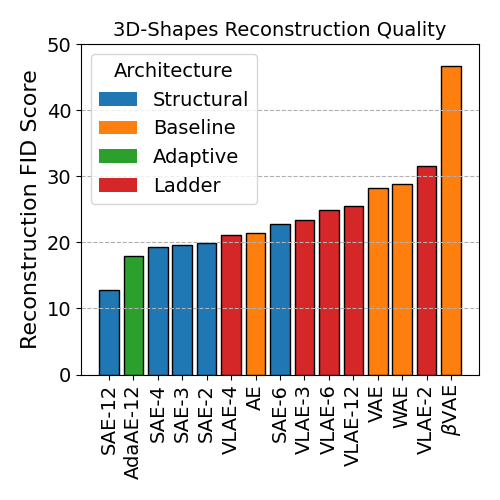

In [32]:
fig, ax = plt.subplots(figsize=(5,5))
# texts = []
tps = set()
x = np.arange(len(title_order))

order = [x[1] for x in sorted((r.stats.rec_fid, r.ident) for r in runs)]
for i,t in enumerate(order):
    r = run_idents[t]
    s = r.stats.rec_fid
    c = info.colors[r.group]
    plt.bar(i, s, color=c, edgecolor='k', )#linewidth=2)
    tps.add(r.group)
plt.xticks(x, [titles[t] for t in order], rotation='vertical')
#     plt.scatter(r.loss, r.fid, color=colors[r.type])
#     texts.append(plt.text(r.loss, r.fid, r.name))
#     tps.add(r.type)
#     plt.scatter(r.fid, r.loss, color=colors[r.type])
#     texts.append(plt.text(r.fid-(fidrg/10 if r.type == 'attn' else 0), r.loss, r.name))
# legend_elements = [Patch(facecolor=info.colors[name], label=info.tnames[name]) for name in set(typs)]
legend_elements = [Patch(facecolor=info.colors[name], label=info.group_names[name]) for name in tps]
legend = plt.legend(handles=legend_elements, title='Architecture')
# plt.ylabel('Reconstruction Loss')
plt.ylabel('Reconstruction FID Score')
plt.title(f'{info.title} Reconstruction Quality')
# plt.yscale('log')
# s = [20,30,40,50,60,70, 80,90,100]
if dscode == 'celeb':
    plt.ylim(80,150)
elif dscode in {'3ds', 'toy'}:
    plt.ylim(0,50)
elif dscode == 'real':
    plt.ylim(0,70)
# else:
#     plt.ylim(0,100)
# plt.ylim(4550,4580)
# plt.yticks(s,map(str,s))
plt.grid(linestyle='--',axis='y')

# legend1 = plt.legend(legend_elements1, ['Hybrid', 'Prior'], loc=4, title='Sampling Method')
# ax.add_artist(legend1, )
# ax.add_artist(legend)
plt.tight_layout()
# util.save_figure(f'{dscode}_rec-fid', **save_figure_kwargs)
pass

In [33]:
scores = []
groups = []
typs = []
names = []

for r in runs:
    if 'hybrid_fid' in r.stats:
        scores.append(r.stats.hybrid_fid if 'hyb_group_fid' not in r.stats else r.stats.hyb_group_fid)
        groups.append(r.group)
        typs.append('hyb')
        names.append(r.title)
    if 'prior_fid' in r.stats:
        scores.append(r.stats.prior_fid)
        groups.append(r.group)
        typs.append('prior')
        names.append(r.title)
#     if 'hyb_group_fid' in r.stats:
#         scores.append(r.stats.hyb_group_fid)
#         groups.append(r.group)
#         typs.append('group')
#         names.append(r.title)
        

scores = np.array(scores)
groups = np.array(groups)
typs = np.array(typs)
names = np.array(names)

order = np.argsort(scores)
scores = scores[order]
groups = groups[order]
typs = typs[order]
names = names[order]

eclrs = [('xx' if t == 'hyb' else ('**' if t=='group' else 'oo')) for t in typs]
clrs = [info.colors[g] for g in groups]

len(scores)

23

<IPython.core.display.Javascript object>


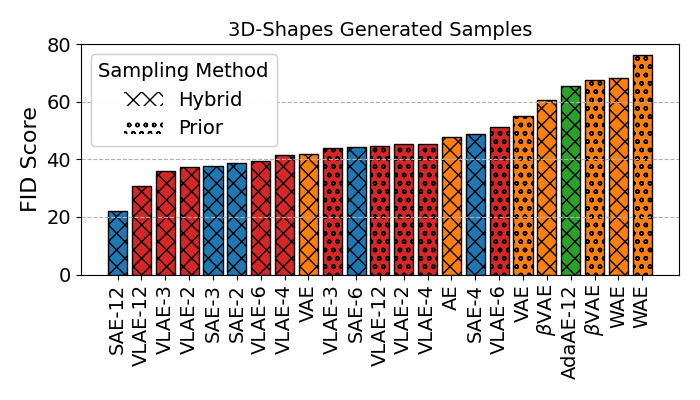

In [40]:
tall = False
if tall:
    fig, ax = plt.subplots(figsize=(6,5))
else:
    fig, ax = plt.subplots(figsize=(7,4))
# texts = []
# tps = set()
x = np.arange(len(names))
for i,s,c,h in zip(x,scores,clrs,eclrs):
    plt.bar(i, s, color=c, edgecolor='k', hatch=h, )#linewidth=2)
plt.xticks(x, names, rotation='vertical')

legend_elements = [Patch(facecolor=info.colors[name], label=info.group_names[name]) for name in set(groups)]
# legend_elements1 = [Patch(facecolor='w', hatch='xxx', label='Hybrid'), Patch(facecolor='w', hatch='ooo', label='Prior')]

# legend_elements1 = [mlines.Line2D([], [], color='k', marker='x', linestyle='None',
#                           markersize=10, label='Hybrid'), 
#                     mlines.Line2D([], [], color='k', marker='o', fillstyle='none', linestyle='None',
#                           markersize=10, label='Prior')]
legend_elements1 = [Patch(facecolor='w', hatch='xx',label='Hybrid'), Patch(facecolor='w', hatch='oo',label='Prior')]
legend_titles = ['Hybrid', 'Prior']
if 'group' in typs:
    
    strctural = 'Strc-Hybrid'
    
    legend_elements1.insert(0, mlines.Line2D([], [], color='k', marker='*', linestyle='None',
                          markersize=10, label=strctural))
    legend_titles.insert(0, strctural)
legend = plt.legend(handles=legend_elements, loc=4, title='Architecture',  framealpha=1)
# plt.xlabel('Reconstruction Loss')
plt.ylabel('FID Score')
plt.title(f'{info.title} Generated Samples')
# plt.yscale('log')
if info.title == 'CelebA':
    plt.ylim(80,150)
elif dscode =='3ds':
    plt.ylim(0,80)
elif dscode == 'toy':
    plt.ylim(0,60)
elif dscode == 'sim':
    plt.ylim(0,100)
elif dscode == 'real':
    plt.ylim(0,90)
else:
    pass
# plt.yticks(s,map(str,s))
plt.grid(linestyle='--',axis='y')

legend1 = plt.legend(legend_elements1, legend_titles, loc=2, title='Sampling Method')
ax.add_artist(legend1, )
# ax.add_artist(legend)
plt.tight_layout()
aden = ''
# aden = 'grp' if include_group_hyb else ''
shape = 'tall' if tall else 'wide'
# util.save_figure(f'{dscode}_gen{aden}_{shape}', **save_figure_kwargs)
pass

# old

In [9]:
runs = Run_Manager(model_names, root=root, override={'device':device}, pbar=tqdm)
run_idents = {r.ident:r for r in runs}
title_order = [t for t in title_order_base if t in run_idents]

runs.map(lambda run: run.get_records())
runs.load_results('metrics', safe=True, load_kwargs={'device':device});
runs.load_results('final-hyb', safe=True, load_kwargs={'device':device});
runs.load_results(info.cut, load_kwargs={'device':device});

def _load_info(run):
    run.info = run.get_config().pull('info', {})
    run.group = groups_idx[run.ident]
    run.title = titles[run.ident]
    run.code = base_codes[run.ident]
runs.map(_load_info);


def _load_fid(run):
    if not hasattr(run, 'stats'):
        run.stats = util.adict()
    run.stats['rec_loss'] = run.records.stats._archive['val']['100000']['loss']['avg']
    e = run.get_datafile(info.cut)
    if 'rec_fid' in e:
        run.stats['rec_fid'] = e['rec_fid']
    if 'hybrid_fid' in e:
        run.stats['hybrid_fid'] = e['hybrid_fid']
    if include_group_hyb and run.has_results('final-hyb'):
        strc = run.get_datafile('final-hyb')
        print(f'using hyb-grp for {run}')
        run.stats['hyb_group_fid'] = strc['hyb-grp_fid']
    
    if 'hyb_group_fid' in run.stats:
        run.stats['old_hybrid_fid'] = run.stats['hybrid_fid']
        run.stats['hybrid_fid'] = run.stats['hyb_group_fid']
    
    if 'prior_fid' in e:
        run.stats['prior_fid'] = e['prior_fid']
    
    if run.has_results('metrics'):
    
        met = run.get_datafile('metrics')

        run.stats['IRS'] = met['scores']['IRS']['avg_score']
        run.stats['DCI'] = met['scores']['DCI']['disentanglement']
        run.stats['SAP'] = met['scores']['SAP']['SAP_score']
        run.stats['MIG'] = met['scores']['MIG']['discrete_mig']
        run.stats['ModExp'] = met['scores']['ModularityExplicitness']['modularity_score']
        run.stats['Response'] = met['scores']['LatentResponses']['disentanglement'].item()
        run.stats['Fairness'] = met['scores']['Fairness']['disentanglement']

        if not hasattr(run, 'data'):
            run.data = util.adict()
        run.data['IRS'] = met['results']['IRS']['IRS_matrix']
        run.data['cov'] = met['results']['UnsupervisedMetrics']['covariance_matrix']
        run.data['SAP'] = met['results']['SAP']['SAP_matrix']
        run.data['DCI'] = met['results']['DCI']['importance_matrix']
        run.data['Response'] = met['results']['LatentResponses']['response_mat']
        run.data['FactorResponse'] = met['results']['LatentResponses']['factor_responses']
    
runs.map(_load_fid);

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

3ds_ae0_e-c12_d-c12_mish_210125-050038 failed
3ds_vae1_e-c12_d-c12_mish_210125-140254 failed
3ds_vae2_e-c12_d-c12_mish_210125-140255 failed
3ds_wae10_e-c12_d-c12_mish_210125-140253 failed
3ds_ae_e-c12_d-s2_mish_210131-150237 failed
3ds_ae_e-c12_d-s3_mish_210201-021841 failed
3ds_ae0_e-c12_d-s4_mish_210125-140253 failed
3ds_ae0_e-c12_d-s6_mish_210125-140253 failed
3ds_ae_e-c12_d-s12_mish-seed5_210131-150235 failed
3ds_ae_e-c12_d-s12_nosplit-mish_210131-150236 failed
3ds_vae1_e-l2_d-l2_mish_210131-150235 failed
3ds_vae1_e-l3_d-l3_mish_210131-150235 failed
3ds_vae1_e-l4_d-l4_mish_210125-134914 failed
3ds_vae1_e-l6_d-l6_mish_210125-140021 failed
3ds_vae1_e-l12_d-l12_mish_210125-140249 failed


Traceback (most recent call last):
  File "/is/ei/fleeb/workspace/code/foundation/omnilearn/op/analysis.py", line 151, in map
    out = fn(run)
  File "/is/ei/fleeb/workspace/code/foundation/omnilearn/op/analysis.py", line 179, in <lambda>
    return self.map(lambda run: run.get_datafile(ident, **load_kwargs), **kwargs)
  File "/is/ei/fleeb/workspace/code/foundation/omnilearn/op/runs.py", line 416, in get_datafile
    return super().get_datafile(ident, root=(self.get_checkpoint_path()/'results'
  File "/is/ei/fleeb/workspace/code/belt/omnibelt/filesystem.py", line 246, in get_datafile
    self._datafiles[fixed] = self._load_datafile(path, ext=ext, **kwargs)
  File "/is/ei/fleeb/workspace/code/foundation/omnilearn/op/loading.py", line 40, in _load_datafile
    return super()._load_datafile(path, name=name, _load_fn=_load_fn, ext=ext, **kwargs)
  File "/is/ei/fleeb/workspace/code/belt/omnibelt/filesystem.py", line 205, in _load_datafile
    return _load_fn(str(path))
  File "/is/ei/fleeb

  0%|          | 0/15 [00:00<?, ?it/s]

3ds_ae0_e-c12_d-c12_mish_210125-050038 failed
3ds_vae1_e-c12_d-c12_mish_210125-140254 failed
3ds_vae2_e-c12_d-c12_mish_210125-140255 failed
3ds_wae10_e-c12_d-c12_mish_210125-140253 failed
3ds_ae_e-c12_d-s2_mish_210131-150237 failed
3ds_ae_e-c12_d-s3_mish_210201-021841 failed
3ds_ae0_e-c12_d-s4_mish_210125-140253 failed
3ds_ae0_e-c12_d-s6_mish_210125-140253 failed
3ds_ae_e-c12_d-s12_mish-seed5_210131-150235 failed
3ds_ae_e-c12_d-s12_nosplit-mish_210131-150236 failed
3ds_vae1_e-l2_d-l2_mish_210131-150235 failed
3ds_vae1_e-l3_d-l3_mish_210131-150235 failed
3ds_vae1_e-l4_d-l4_mish_210125-134914 failed


Traceback (most recent call last):
  File "/is/ei/fleeb/workspace/code/foundation/omnilearn/op/analysis.py", line 151, in map
    out = fn(run)
  File "/is/ei/fleeb/workspace/code/foundation/omnilearn/op/analysis.py", line 179, in <lambda>
    return self.map(lambda run: run.get_datafile(ident, **load_kwargs), **kwargs)
  File "/is/ei/fleeb/workspace/code/foundation/omnilearn/op/runs.py", line 416, in get_datafile
    return super().get_datafile(ident, root=(self.get_checkpoint_path()/'results'
  File "/is/ei/fleeb/workspace/code/belt/omnibelt/filesystem.py", line 246, in get_datafile
    self._datafiles[fixed] = self._load_datafile(path, ext=ext, **kwargs)
  File "/is/ei/fleeb/workspace/code/foundation/omnilearn/op/loading.py", line 40, in _load_datafile
    return super()._load_datafile(path, name=name, _load_fn=_load_fn, ext=ext, **kwargs)
  File "/is/ei/fleeb/workspace/code/belt/omnibelt/filesystem.py", line 205, in _load_datafile
    return _load_fn(str(path))
  File "/is/ei/fleeb

3ds_vae1_e-l6_d-l6_mish_210125-140021 failed
3ds_vae1_e-l12_d-l12_mish_210125-140249 failed


Traceback (most recent call last):
  File "/is/ei/fleeb/workspace/code/foundation/omnilearn/op/analysis.py", line 151, in map
    out = fn(run)
  File "/is/ei/fleeb/workspace/code/foundation/omnilearn/op/analysis.py", line 179, in <lambda>
    return self.map(lambda run: run.get_datafile(ident, **load_kwargs), **kwargs)
  File "/is/ei/fleeb/workspace/code/foundation/omnilearn/op/runs.py", line 416, in get_datafile
    return super().get_datafile(ident, root=(self.get_checkpoint_path()/'results'
  File "/is/ei/fleeb/workspace/code/belt/omnibelt/filesystem.py", line 246, in get_datafile
    self._datafiles[fixed] = self._load_datafile(path, ext=ext, **kwargs)
  File "/is/ei/fleeb/workspace/code/foundation/omnilearn/op/loading.py", line 40, in _load_datafile
    return super()._load_datafile(path, name=name, _load_fn=_load_fn, ext=ext, **kwargs)
  File "/is/ei/fleeb/workspace/code/belt/omnibelt/filesystem.py", line 205, in _load_datafile
    return _load_fn(str(path))
  File "/is/ei/fleeb

  0%|          | 0/15 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: '/is/ei/fleeb/workspace/chome/old_trained_nets/3ds_ae0_e-c12_d-c12_mish_210125-050038/ckpt100000/results/eval.pk'

In [10]:
run = runs[8]
run

INLINE_TIMED_SAE_RUN:3ds_ae_e-c12_d-s12_mish-seed5_210131-150235

In [11]:
# fig, ax = plt.subplots(figsize=info.fsize)

# objs = []
# texts = []
# tps = set()
# for r in runs:
#     objs.append(plt.scatter(r.stats.rec_loss, r.stats.rec_fid, color=info.colors[r.group]))
#     texts.append(plt.text(r.stats.rec_loss, r.stats.rec_fid, r.code, horizontalalignment='center',
#       verticalalignment='center',))
#     tps.add(r.group)

# legend_elements = [Patch(facecolor=info.colors[name], label=info.group_names[name]) for name in tps]
# plt.legend(handles=legend_elements, title='Architecture')
# plt.xlabel('Reconstruction Loss')
# plt.ylabel('Reconstruction FID Score')
# plt.title(f'{info.title} Reconstruction Quality')
# # plt.xlim(left=6370)
# # plt.ylim(bottom=0)
# plt.tight_layout()
# # adjust_text(texts, #force_text=(0.1,0.1)
# #             #force_text=(0.1,0.25),
# #             add_objects=objs,
# #            )
# pass
# util.save_figure(f'{dscode}_rec_quality', **save_figure_kwargs)

<IPython.core.display.Javascript object>


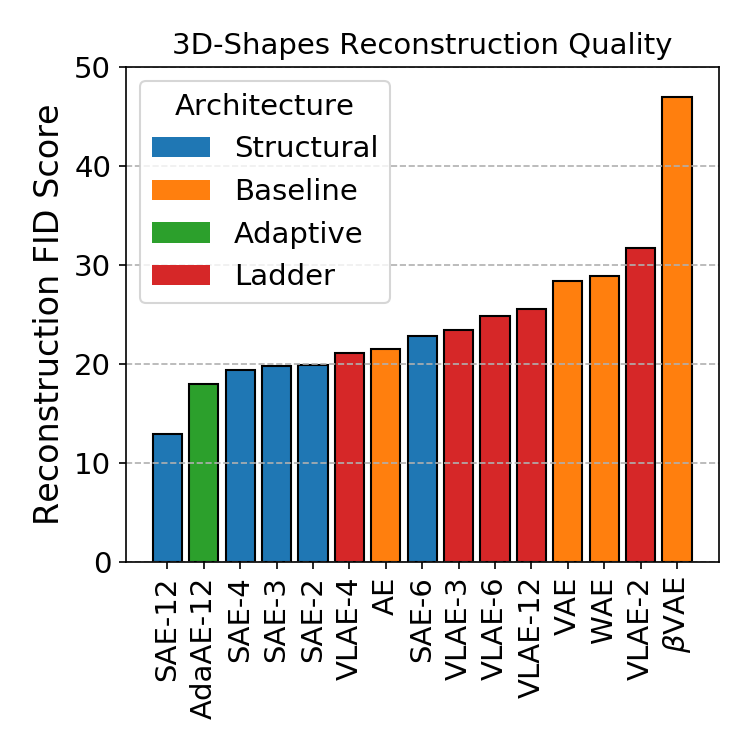

Figure 3ds_rec-fid saved as {'png', 'pdf'}


In [12]:
fig, ax = plt.subplots(figsize=(5,5))
# texts = []
tps = set()
x = np.arange(len(title_order))

order = [x[1] for x in sorted((r.stats.rec_fid, r.ident) for r in runs)]
for i,t in enumerate(order):
    r = run_idents[t]
    s = r.stats.rec_fid
    c = info.colors[r.group]
    plt.bar(i, s, color=c, edgecolor='k', )#linewidth=2)
    tps.add(r.group)
plt.xticks(x, [titles[t] for t in order], rotation='vertical')
#     plt.scatter(r.loss, r.fid, color=colors[r.type])
#     texts.append(plt.text(r.loss, r.fid, r.name))
#     tps.add(r.type)
#     plt.scatter(r.fid, r.loss, color=colors[r.type])
#     texts.append(plt.text(r.fid-(fidrg/10 if r.type == 'attn' else 0), r.loss, r.name))
# legend_elements = [Patch(facecolor=info.colors[name], label=info.tnames[name]) for name in set(typs)]
legend_elements = [Patch(facecolor=info.colors[name], label=info.group_names[name]) for name in tps]
legend = plt.legend(handles=legend_elements, title='Architecture')
# plt.ylabel('Reconstruction Loss')
plt.ylabel('Reconstruction FID Score')
plt.title(f'{info.title} Reconstruction Quality')
# plt.yscale('log')
# s = [20,30,40,50,60,70, 80,90,100]
if dscode == 'celeb':
    plt.ylim(80,150)
elif dscode in {'3ds', 'toy'}:
    plt.ylim(0,50)
elif dscode == 'real':
    plt.ylim(0,70)
# else:
#     plt.ylim(0,100)
# plt.ylim(4550,4580)
# plt.yticks(s,map(str,s))
plt.grid(linestyle='--',axis='y')

# legend1 = plt.legend(legend_elements1, ['Hybrid', 'Prior'], loc=4, title='Sampling Method')
# ax.add_artist(legend1, )
# ax.add_artist(legend)
plt.tight_layout()
util.save_figure(f'{dscode}_rec-fid', **save_figure_kwargs)
pass

In [13]:
scores = []
groups = []
typs = []
names = []

for r in runs:
    if 'hybrid_fid' in r.stats:
        scores.append(r.stats.hybrid_fid if 'hyb_group_fid' not in r.stats else r.stats.hyb_group_fid)
        groups.append(r.group)
        typs.append('hyb')
        names.append(r.title)
    if 'prior_fid' in r.stats:
        scores.append(r.stats.prior_fid)
        groups.append(r.group)
        typs.append('prior')
        names.append(r.title)
#     if 'hyb_group_fid' in r.stats:
#         scores.append(r.stats.hyb_group_fid)
#         groups.append(r.group)
#         typs.append('group')
#         names.append(r.title)
        

scores = np.array(scores)
groups = np.array(groups)
typs = np.array(typs)
names = np.array(names)

order = np.argsort(scores)
scores = scores[order]
groups = groups[order]
typs = typs[order]
names = names[order]

eclrs = [('xx' if t == 'hyb' else ('**' if t=='group' else 'oo')) for t in typs]
clrs = [info.colors[g] for g in groups]

len(scores)

23

<IPython.core.display.Javascript object>


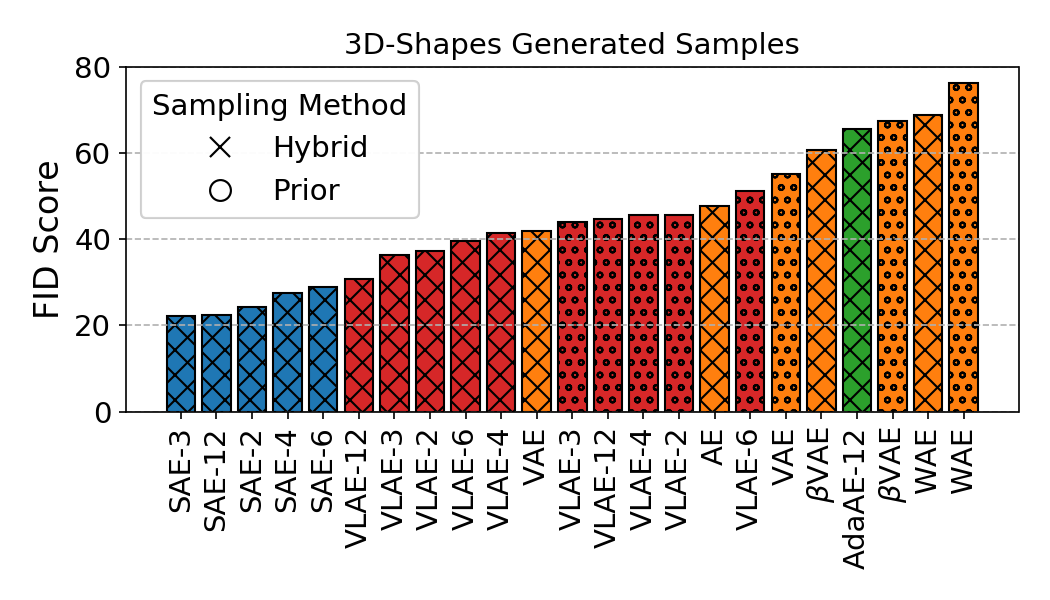

Figure 3ds_gen_wide saved as {'png', 'pdf'}


In [16]:
tall = False
if tall:
    fig, ax = plt.subplots(figsize=(6,5))
else:
    fig, ax = plt.subplots(figsize=(7,4))
# texts = []
# tps = set()
x = np.arange(len(names))
for i,s,c,h in zip(x,scores,clrs,eclrs):
    plt.bar(i, s, color=c, edgecolor='k', hatch=h, )#linewidth=2)
plt.xticks(x, names, rotation='vertical')

legend_elements = [Patch(facecolor=info.colors[name], label=info.group_names[name]) for name in set(groups)]
# legend_elements1 = [Patch(facecolor='w', hatch='xxx', label='Hybrid'), Patch(facecolor='w', hatch='ooo', label='Prior')]

legend_elements1 = [mlines.Line2D([], [], color='k', marker='x', linestyle='None',
                          markersize=10, label='Hybrid'), 
                    mlines.Line2D([], [], color='k', marker='o', fillstyle='none', linestyle='None',
                          markersize=10, label='Prior')]
legend_titles = ['Hybrid', 'Prior']
if 'group' in typs:
    
    strctural = 'Strc-Hybrid'
    
    legend_elements1.insert(0, mlines.Line2D([], [], color='k', marker='*', linestyle='None',
                          markersize=10, label=strctural))
    legend_titles.insert(0, strctural)
legend = plt.legend(handles=legend_elements, loc=4, title='Architecture',  framealpha=1)
# plt.xlabel('Reconstruction Loss')
plt.ylabel('FID Score')
plt.title(f'{info.title} Generated Samples')
# plt.yscale('log')
if info.title == 'CelebA':
    plt.ylim(80,150)
elif dscode =='3ds':
    plt.ylim(0,80)
elif dscode == 'toy':
    plt.ylim(0,60)
elif dscode == 'sim':
    plt.ylim(0,100)
elif dscode == 'real':
    plt.ylim(0,90)
else:
    pass
# plt.yticks(s,map(str,s))
plt.grid(linestyle='--',axis='y')

legend1 = plt.legend(legend_elements1, legend_titles, loc=2, title='Sampling Method')
ax.add_artist(legend1, )
# ax.add_artist(legend)
plt.tight_layout()
aden = ''
# aden = 'grp' if include_group_hyb else ''
shape = 'tall' if tall else 'wide'
util.save_figure(f'{dscode}_gen{aden}_{shape}', **save_figure_kwargs)
pass

In [17]:
run.results[info.cut].keys()

odict_keys(['device', 'original', 'batch', 'latent', 'reconstruction', 'rec_loss', 'loss', 'diffs', 'rec_fid_stats', 'rec_fid', 'hybrid_fid_stats', 'hybrid_fid', '_size_key'])

In [18]:
title_order

['AE S12',
 'AE S6',
 'AE S4',
 'AE S3',
 'AE S2',
 'VAE1 L12',
 'VAE1 L6',
 'VAE1 L4',
 'VAE1 L3',
 'VAE1 L2',
 'AE S12 nosplit',
 'AE',
 'VAE1',
 'VAE2',
 'WAE10']

In [19]:
run.stats.keys()

odict_keys(['rec_loss', 'rec_fid', 'hybrid_fid', 'IRS', 'DCI', 'SAP', 'MIG', 'ModExp', 'Response', 'Fairness'])

In [20]:
picks = ['Response', 'IRS', 'DCI', 'SAP', 'MIG', 'ModExp']


<IPython.core.display.Javascript object>


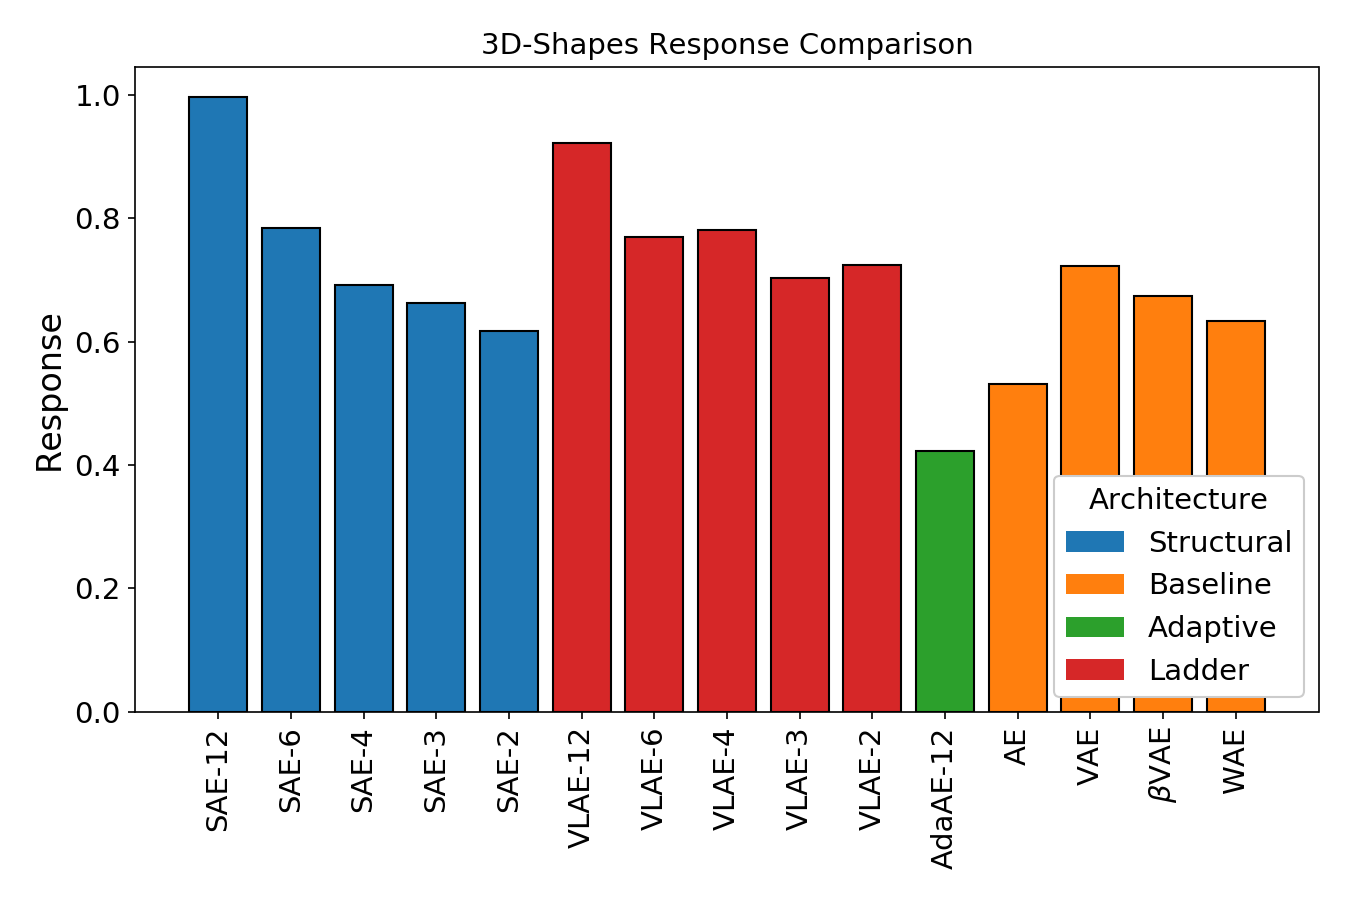

<IPython.core.display.Javascript object>


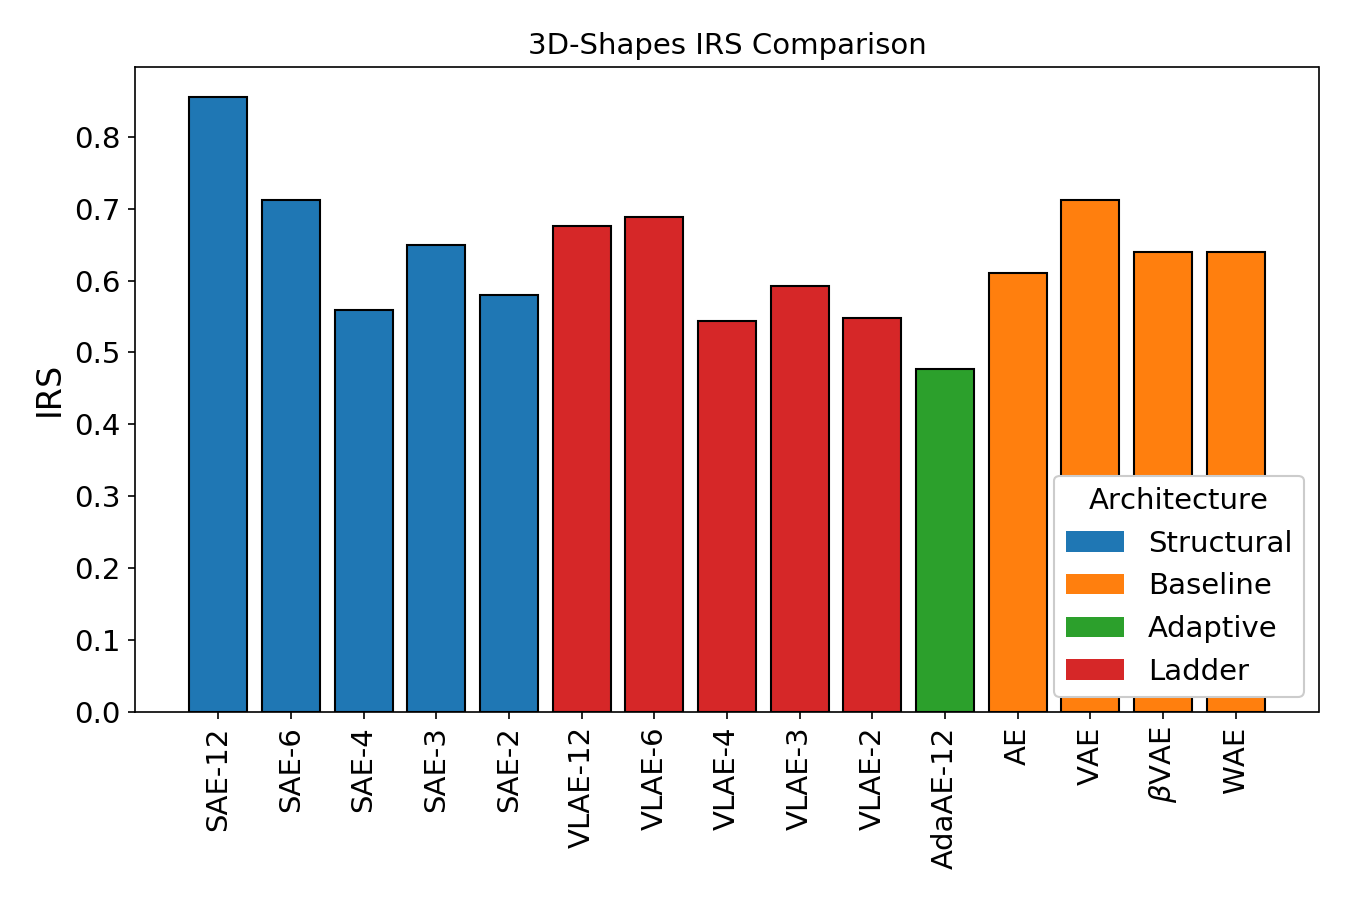

<IPython.core.display.Javascript object>


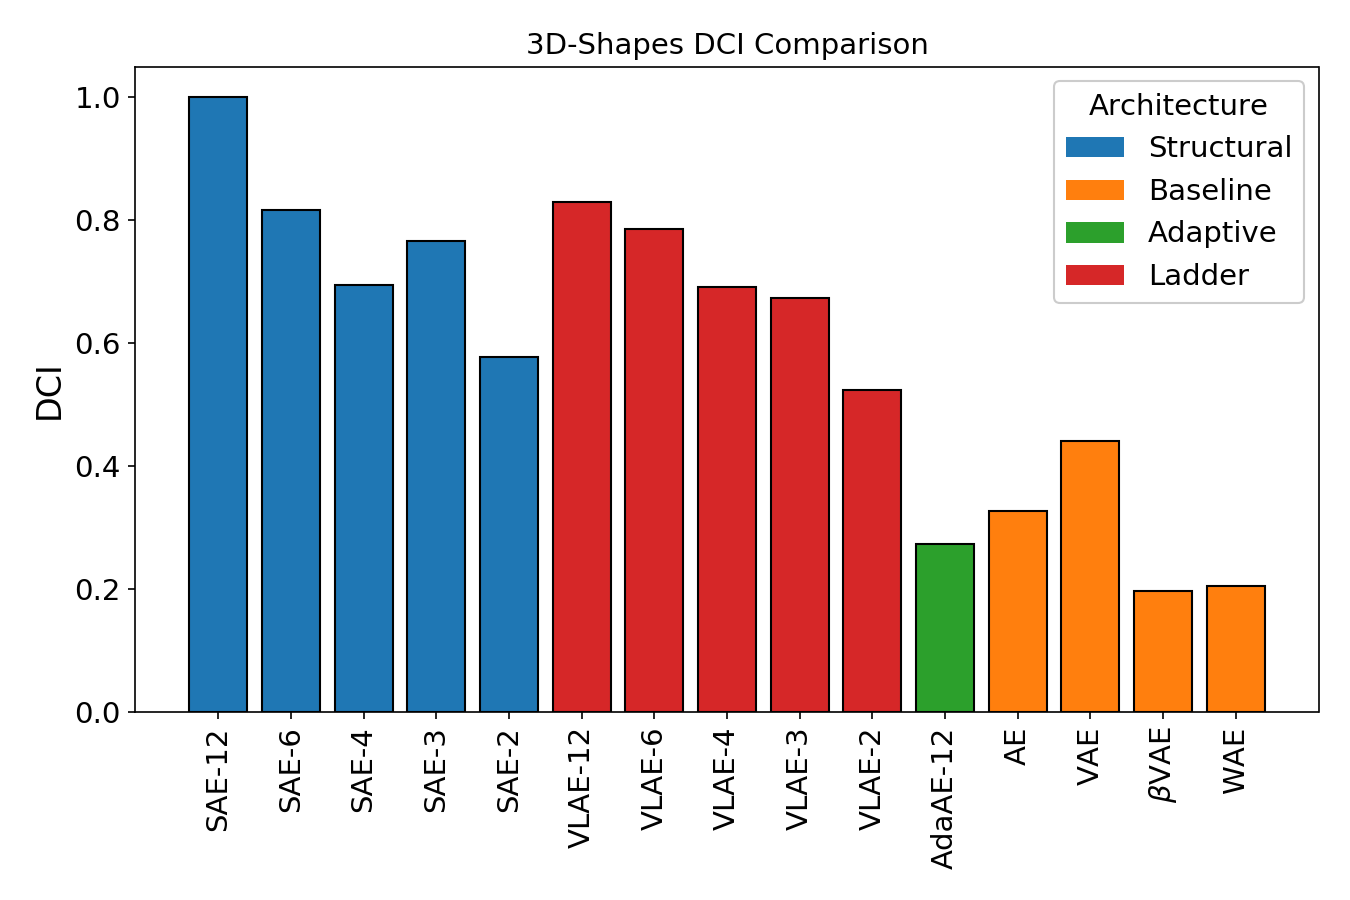

<IPython.core.display.Javascript object>


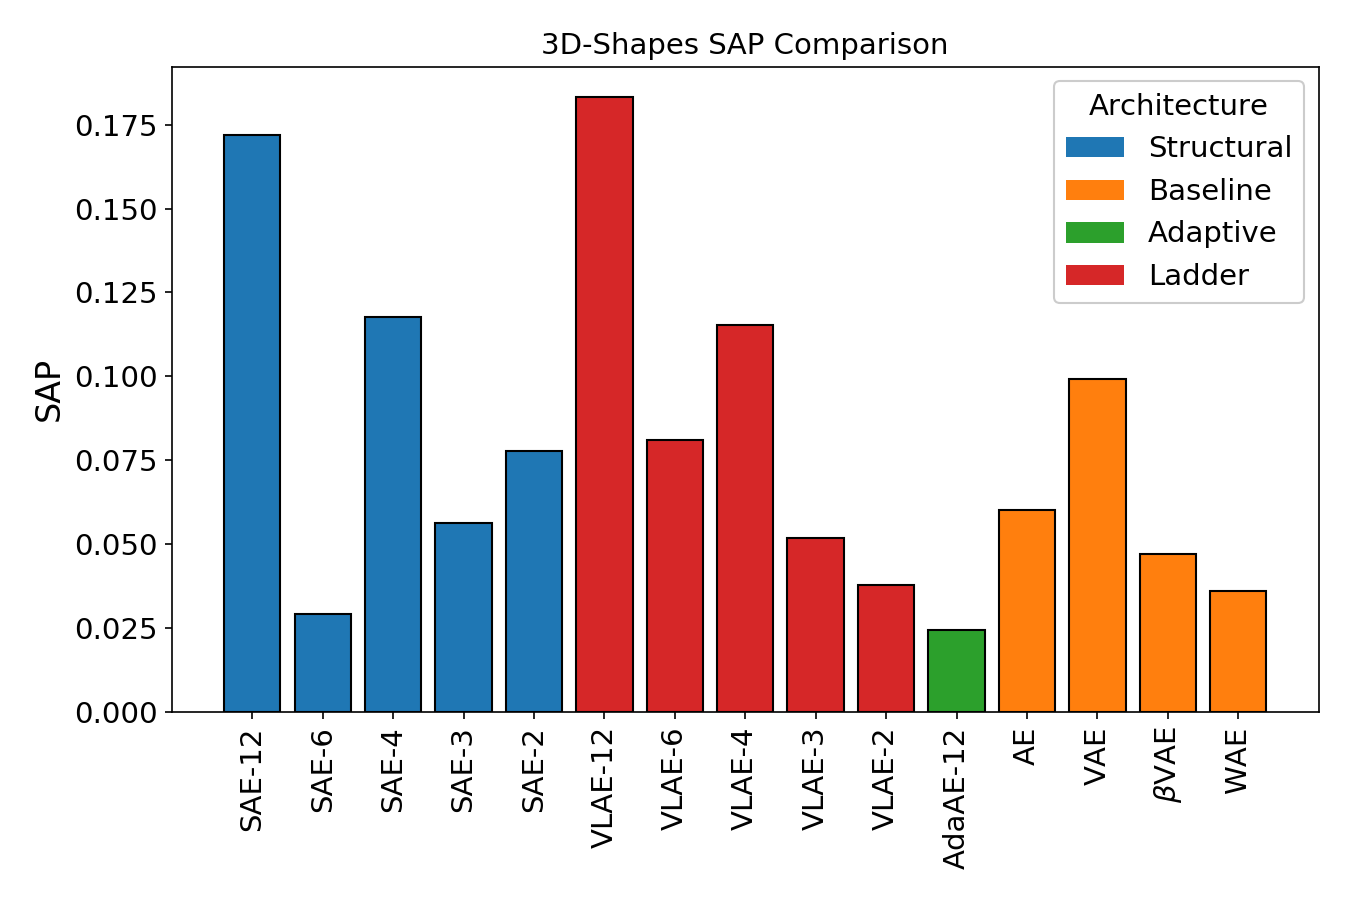

<IPython.core.display.Javascript object>


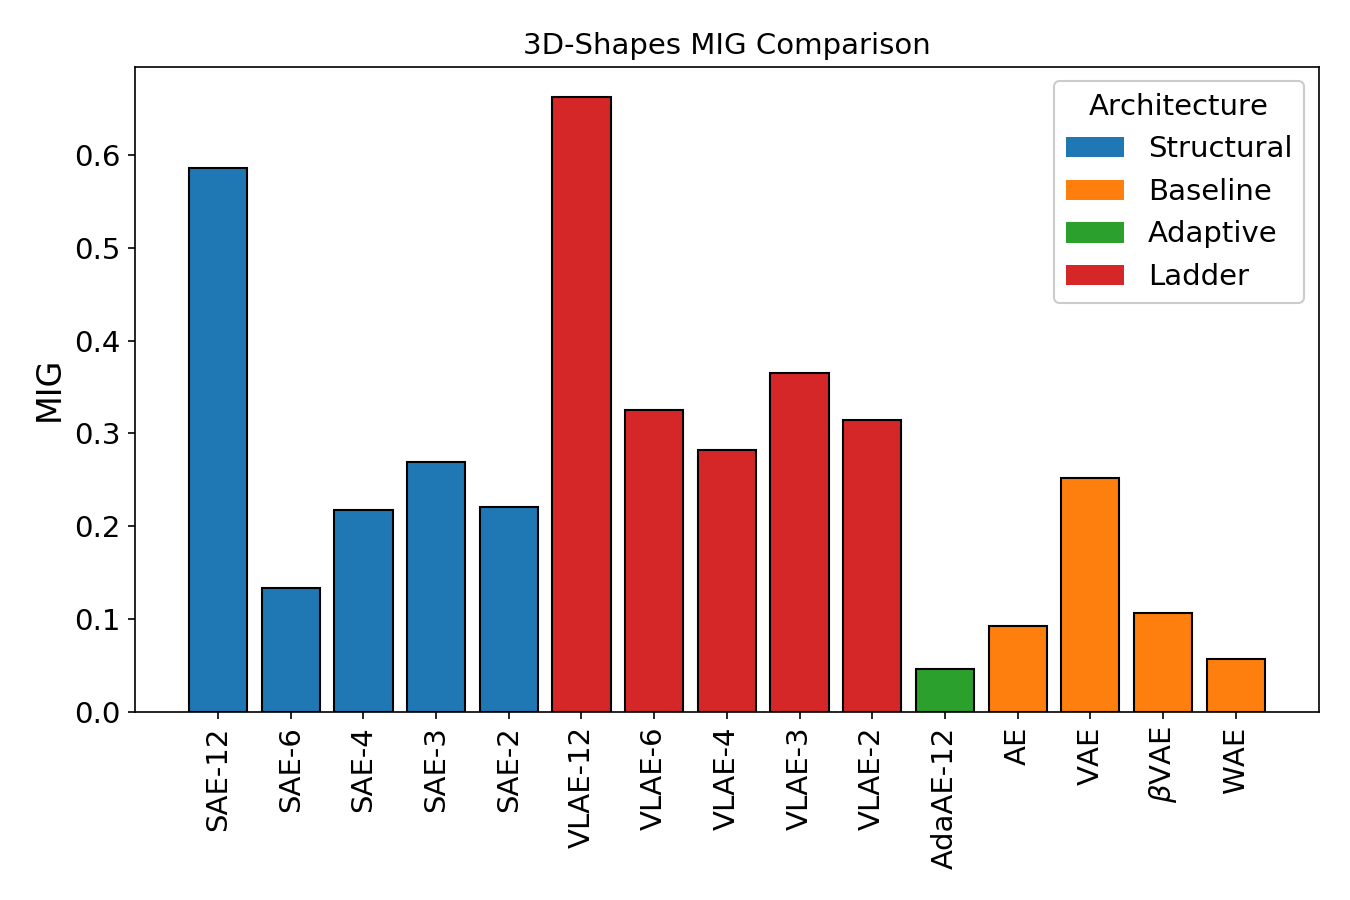

<IPython.core.display.Javascript object>


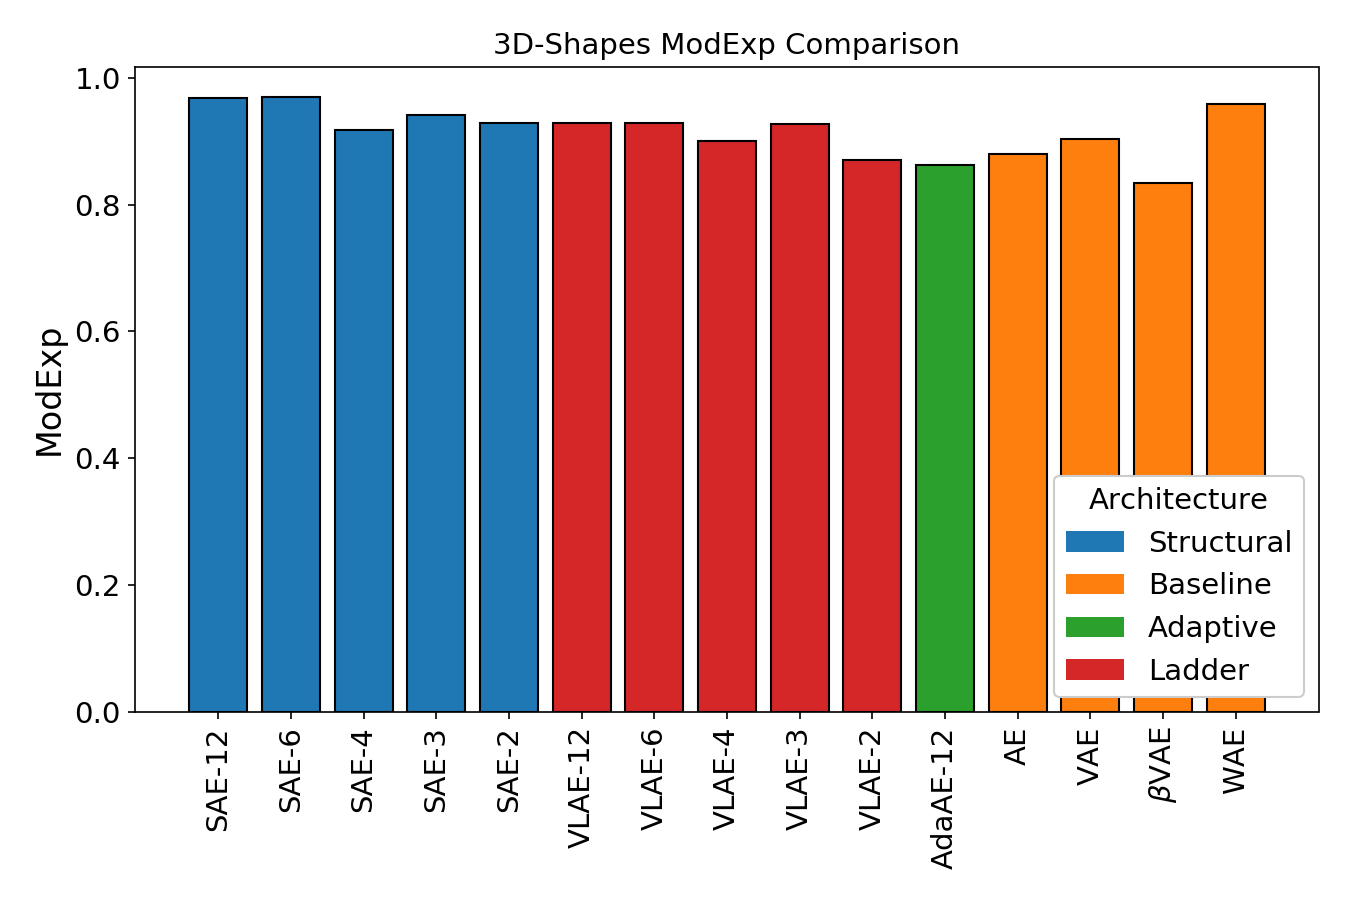

In [21]:
for pick in picks:
    fig, ax = plt.subplots(figsize=info.fsize)
    x = np.arange(len(title_order))
    mu = 0
    mx = None
    for i,t in enumerate(title_order):
        r = run_idents[t]
        s = r.stats[pick]
        if mx is None or s > mx:
            mx = s
        mu += s
        c = info.colors[r.group]
        plt.bar(i, s, color=c, edgecolor='k', )
    plt.xticks(x, [titles[t] for t in title_order], rotation='vertical')
    mu /= len(title_order)
    
    legend_elements = [Patch(facecolor=info.colors[name], label=info.group_names[name]) for name in set(info.group_names)]
#     legend = plt.legend(handles=legend_elements, loc=4, title='Architecture',  framealpha=1)
    
    legend = plt.legend(handles=legend_elements, loc=(4 if 2*mx/3 < mu else 1), title='Architecture',  framealpha=1)

    # plt.xlabel('Reconstruction Loss')
    plt.ylabel(f'{pick}')
    plt.title(f'{info.title} {pick} Comparison')
    plt.tight_layout()
#     util.save_figure(f'{dscode}_{pick}', **save_figure_kwargs)
    pass

In [22]:
run.data.keys()

odict_keys(['IRS', 'cov', 'SAP', 'DCI', 'Response', 'FactorResponse'])

In [33]:
mat_name = 'FactorResponse'
# mat_name = 'Response'
# mat_name = 'DCI'

In [34]:
allRs = {r.ident:r.data[mat_name] for r in runs}
if mat_name == 'FactorResponse':
    allRs = {k: v.min(1)[0].max(-1)[0] for k,v in allRs.items()}
if mat_name in {'DCI', 'IRS', 'SAP'}:
    allRs = {k: v.T for k,v in allRs.items()}

allRs.keys()

dict_keys(['AE', 'VAE1', 'VAE2', 'WAE10', 'AE S2', 'AE S3', 'AE S4', 'AE S6', 'AE S12', 'AE S12 nosplit', 'VAE1 L2', 'VAE1 L3', 'VAE1 L4', 'VAE1 L6', 'VAE1 L12'])

In [35]:
factor_order = ['object_color', 'object_shape', 'object_size', 'camera_height', 'background_color',
		                     'horizonal_axis', 'vertical_axis'] if dscode in {'toy', 'sim',  'real'} else ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape', 'orientation']
factors = {'floor_hue': 'Floor Hue', 'wall_hue': 'Wall Hue', 'object_hue': 'Object Hue', 'scale': 'Scale', 'shape': 'Shape', 'orientation': 'Orientation'}


In [36]:
nax = 15
H,W = util.calc_tiling(nax)
H,W

(3, 5)

<IPython.core.display.Javascript object>


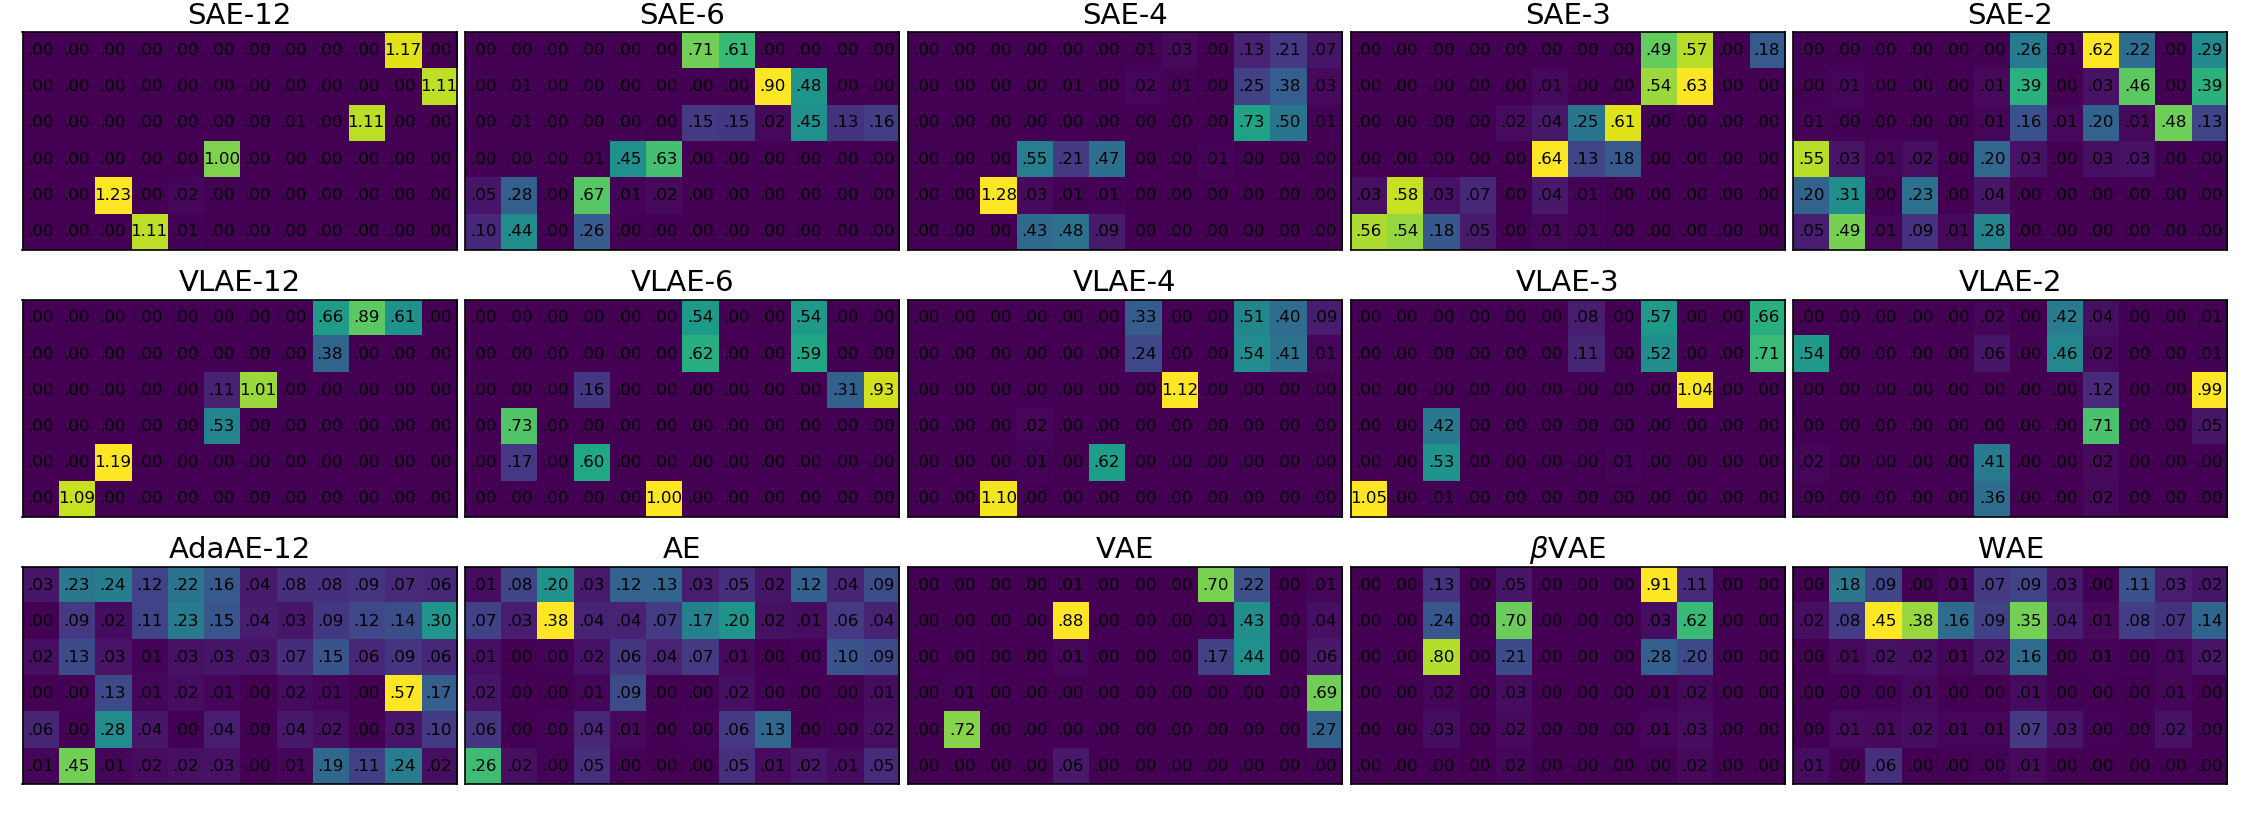

Figure 3ds_FactorResponse_matrices saved as {'png', 'pdf'}


In [37]:
fg, axes = plt.subplots(H,W, figsize=(15,10) if mat_name == 'Response' else (15,5.5))
axes = axes.reshape(-1)

for ax, title in zip(axes, title_order):
    plt.sca(ax)
    
    Rs = allRs[title]
    
#     util.plot_mat(Rs.mean(0), val_fmt=1, figax=(fg, ax));
    util.plot_mat(Rs, val_fmt=lambda x: f'{x:.2f}'.lstrip('0'), figax=(fg, ax), text_kwargs={'size':8});
    plt.xticks([])
    plt.yticks([])
    plt.title(run_idents[title].title, pad=-1)

    
for i in range(len(allRs), nax):
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.15, wspace=0.02, bottom=0.04, top=0.97, left=0.01, right=0.99)
util.save_figure(f'{dscode}_{mat_name}_matrices', **save_figure_kwargs)

In [13]:
M, F, R = run.data['Response'], run.data['FactorResponse'].min(1)[0].max(-1)[0], run.data['DCI'].T
M.shape, F.shape, R.shape

(torch.Size([12, 12]), torch.Size([6, 12]), (6, 12))

<IPython.core.display.Javascript object>


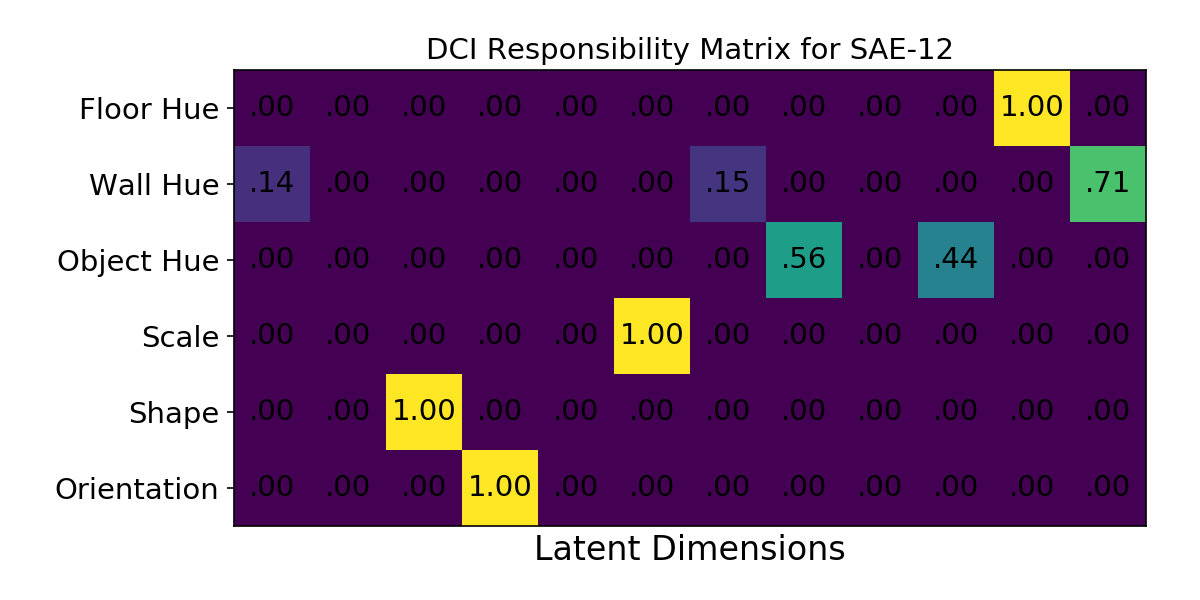

Figure 3ds_S12_dci-mat saved as {'png', 'pdf'}


In [19]:
fg, ax = plt.subplots(figsize=(8,4))
util.plot_mat(R, val_fmt=lambda x: f'{x:.2f}'.lstrip('0'), text_kwargs={'size':14}, figax=(fg,ax))
plt.xticks([])
plt.yticks(np.arange(len(factor_order)), [factors[f] for f in factor_order])
plt.title(f'DCI Responsibility Matrix for {run.title}', pad=-6)
plt.xlabel('Latent Dimensions')
plt.tight_layout()
util.save_figure(f'{dscode}_{run.code}_dci-mat', **save_figure_kwargs)
pass

<IPython.core.display.Javascript object>


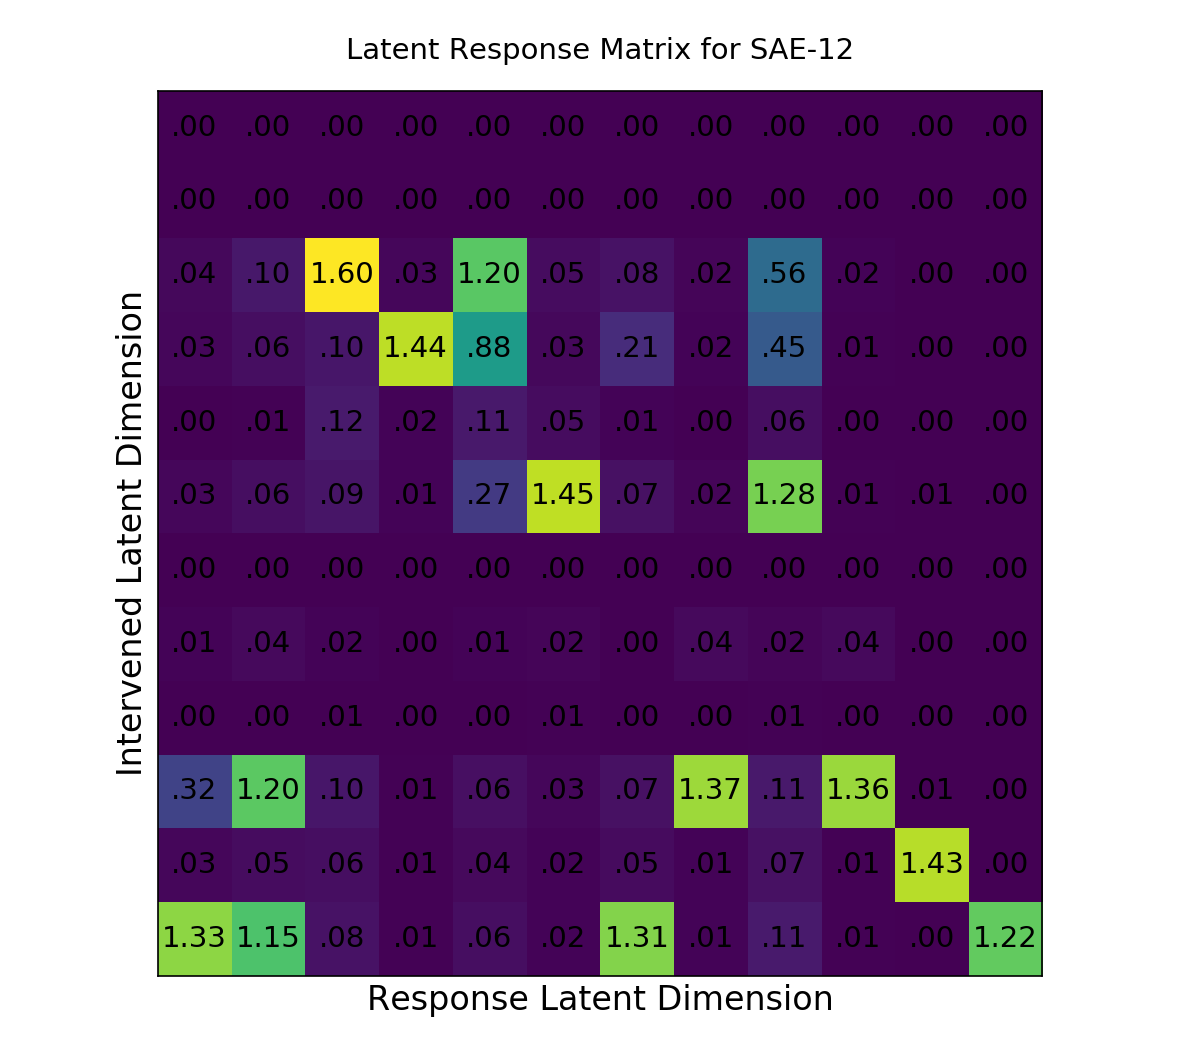

Figure 3ds_S12_response-mat saved as {'png', 'pdf'}


In [20]:
fg, ax = plt.subplots(figsize=(8,7))
util.plot_mat(M, val_fmt=lambda x: f'{x:.2f}'.lstrip('0'), text_kwargs={'size':14}, figax=(fg,ax))
plt.xticks([])
plt.yticks([])
# ax.xaxis.set_label_position('bottom') 
plt.title(f'Latent Response Matrix for {run.title}', pad=-6)
plt.xlabel('Response Latent Dimension')
plt.ylabel('Intervened Latent Dimension')
plt.tight_layout()
util.save_figure(f'{dscode}_{run.code}_response-mat', **save_figure_kwargs)
pass

<IPython.core.display.Javascript object>


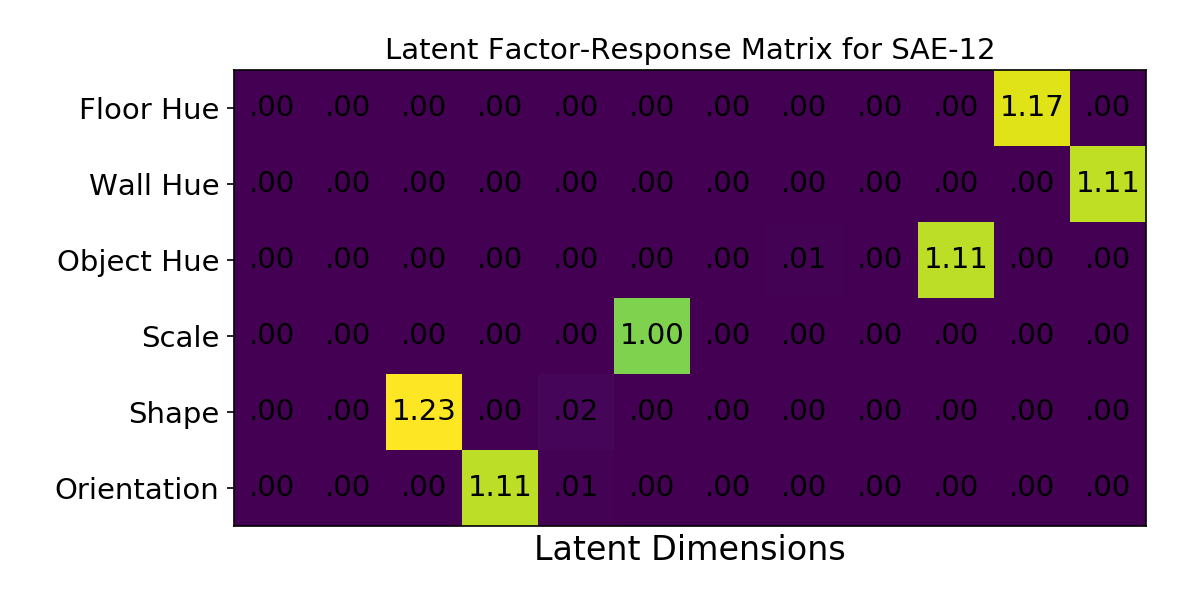

Figure 3ds_S12_factor-mat saved as {'png', 'pdf'}


In [21]:
fg, ax = plt.subplots(figsize=(8,4))
util.plot_mat(F, val_fmt=lambda x: f'{x:.2f}'.lstrip('0'), text_kwargs={'size':14}, figax=(fg,ax))
plt.xticks([])
plt.yticks(np.arange(len(factor_order)), [factors[f] for f in factor_order])
plt.title(f'Latent Factor-Response Matrix for {run.title}', pad=-6)
plt.xlabel('Latent Dimensions')
plt.tight_layout()
util.save_figure(f'{dscode}_{run.code}_factor-mat', **save_figure_kwargs)
pass

In [14]:
met = run.get_results('metrics')
met.keys()

dict_keys(['scores', 'results'])

In [15]:
met['scores']['DCI']

{'informativeness_train': 1.0,
 'informativeness_test': 1.0,
 'disentanglement': 0.998901605470422,
 'completeness': 0.8996158534700882}